# Combination of fits of different models

In [5]:

""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
import seaborn as sns
from collections import defaultdict
import pandas as pd

from one.api import ONE
from jax import vmap
from pprint import pprint
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
# from dynamax.hidden_markov_model import GaussianHMM
from dynamax.hidden_markov_model import LinearAutoregressiveHMM
from dynamax.hidden_markov_model import PoissonHMM

# Get my functionssessions_to_process
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//2_fit_models/'
#functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from fitting_functions import compute_inputs

functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//3_postprocess_results/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from postprocessing_functions import best__kappa, best_lag_kappa, plot_grid_search
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//2_fit_models/'
#functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files
one = ONE(mode='remote')

## Parameters

In [6]:
# Parameters
bin_size = 0.017
num_states = 2
num_iters = 100
num_train_batches = 5
method = 'prior'
threshold = 0.05
sticky = False

save_path = '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/'  + str(bin_size) + '/'+str(num_states)+'_states/most_likely_states/'

# LOAD DATA
data_path ='/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v5_15Jan2025/' + str(bin_size) + '/'
all_files = os.listdir(data_path)
design_matrices = [item for item in all_files if 'design_matrix' in item and 'standardized' not in item]
idxs, mouse_names = idxs_from_files(design_matrices, bin_size)


use_sets = [['avg_wheel_vel'], ['whisker_me'], ['Lick count'], ['0.25', '0.5',
    '1.0', '2.0', '4.0', '8.0', '16.0']]
var_interest_map = ['avg_wheel_vel', 'whisker_me', 'Lick count', 'wavelet']
idx_init_list = [0, 1, 2, 3]
idx_end_list = [1, 2, 3, 9]
var_interest = 'Lick count'


# Individual sessions

In [7]:
# Identify sessions availableto process
grid_search_path = '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/'  + str(bin_size) + '/'+str(num_states)+'_states/grid_search/individual_sessions/'
sessions_to_process = []
for m, mat in enumerate(idxs):
    mouse_name = mat[37:]
    session = mat[:36]
    fit_id = str(mouse_name + session)
    result_filename = os.path.join(grid_search_path, f"{'best_sticky' if sticky else 'best'}_results_{var_interest}_{fit_id}")
    if os.path.exists(result_filename):
        sessions_to_process.append((mouse_name, session))

print(f"Found {len(sessions_to_process)} sessions to process.")

Found 73 sessions to process.


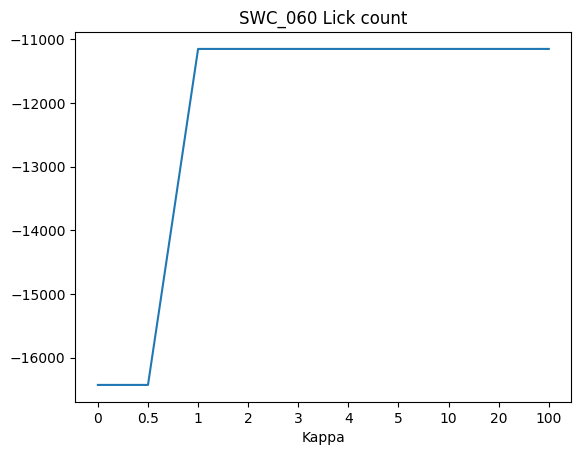

100


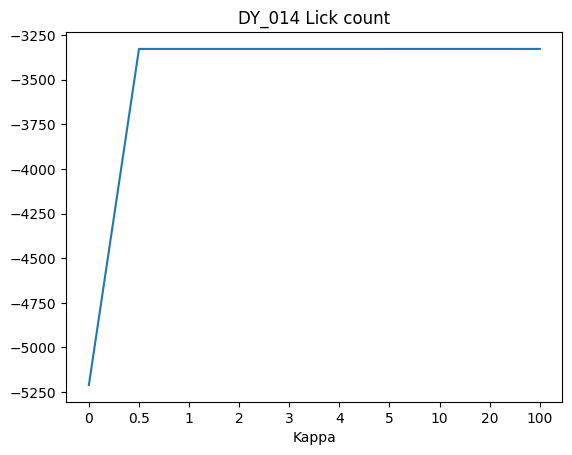

10


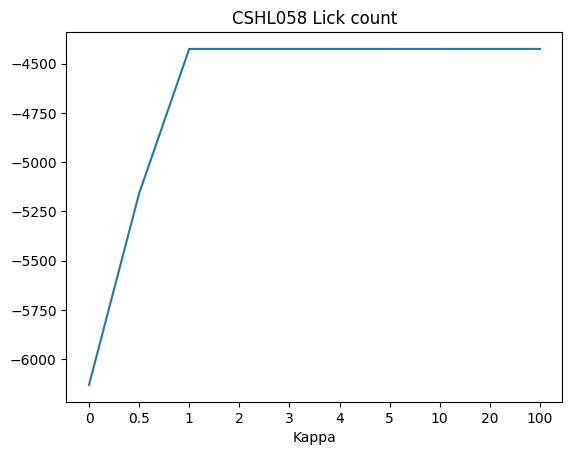

20


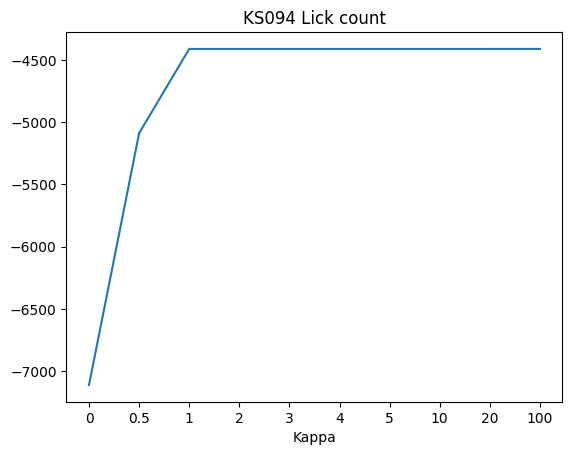

100


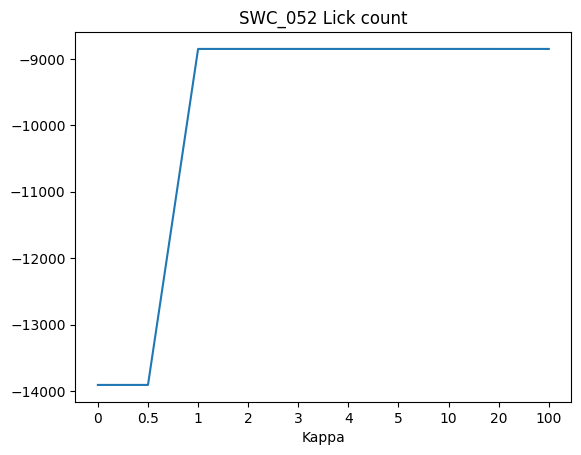

10


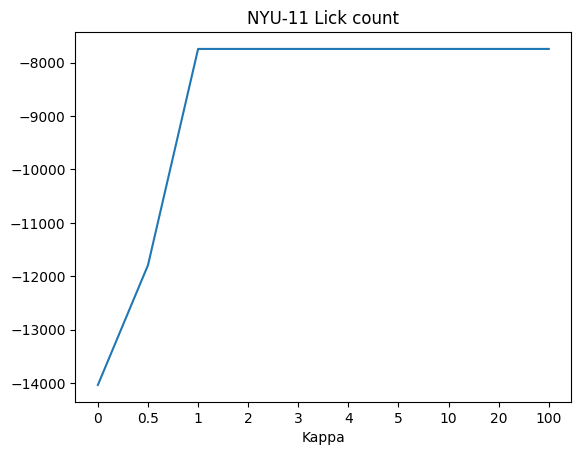

3


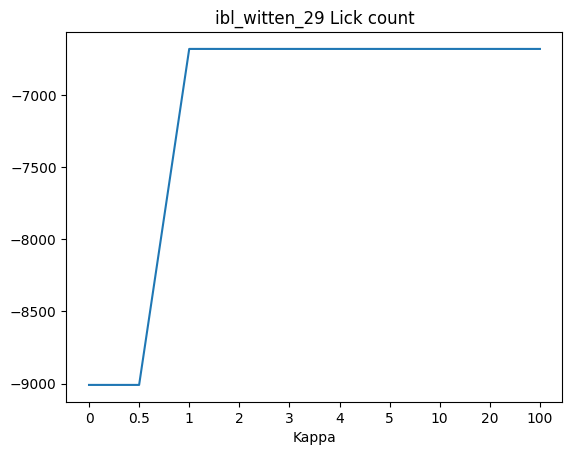

1


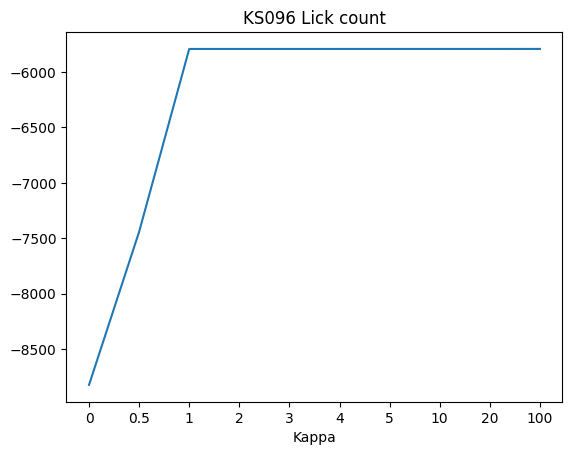

100


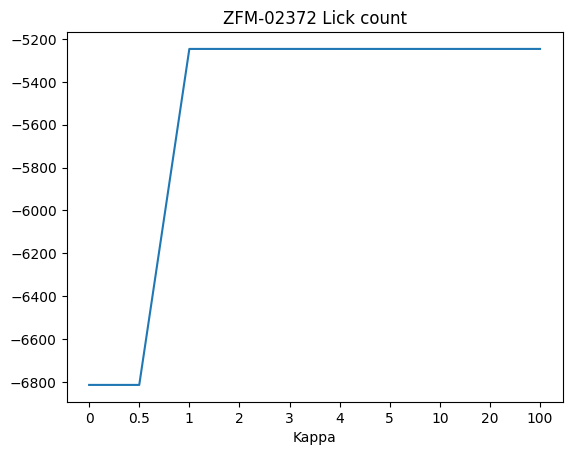

20


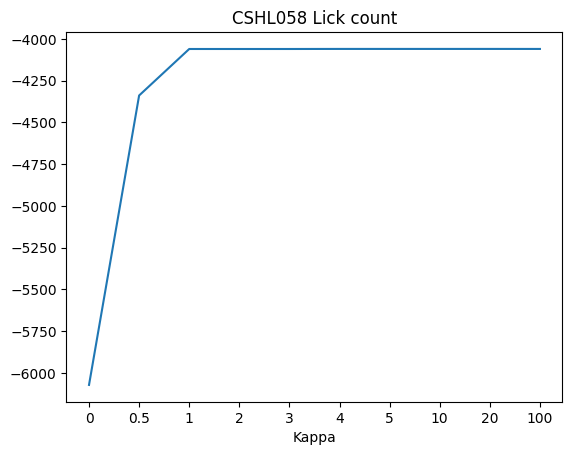

20


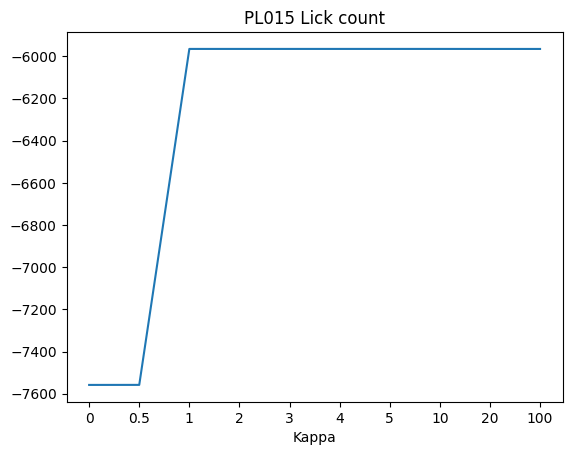

5


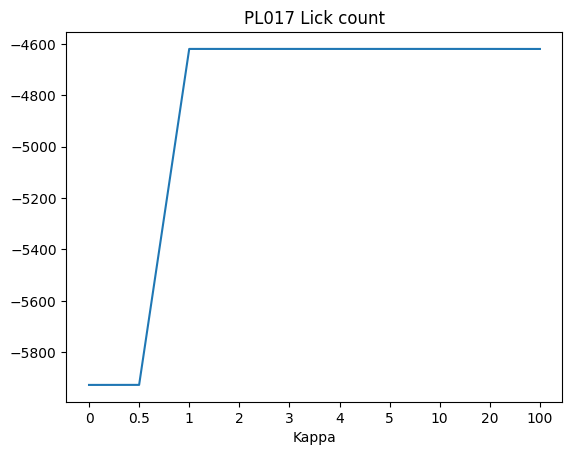

10


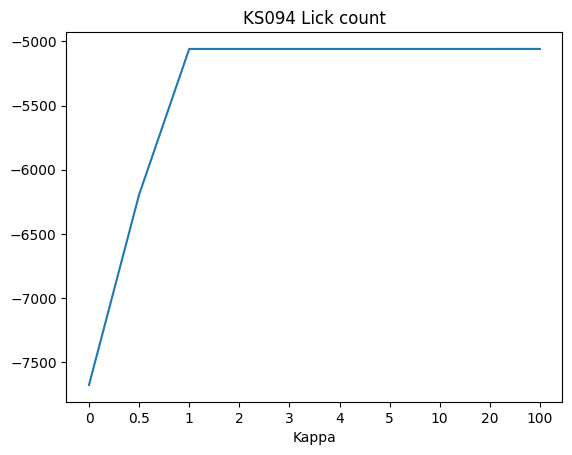

100


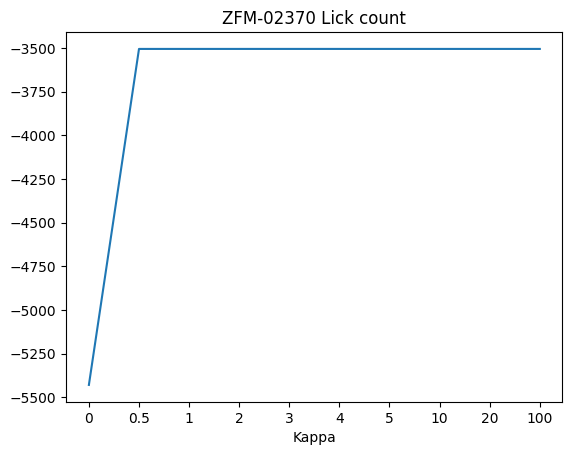

3


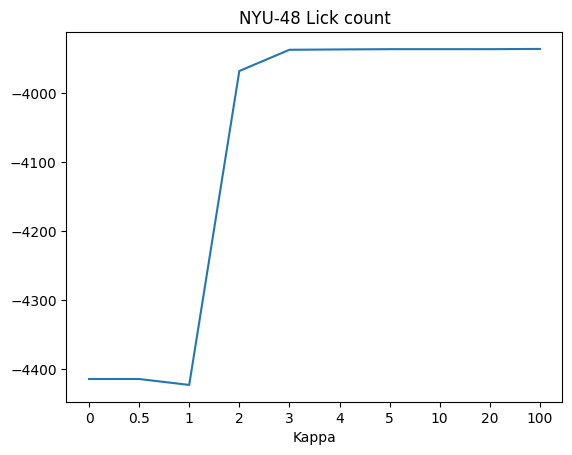

100


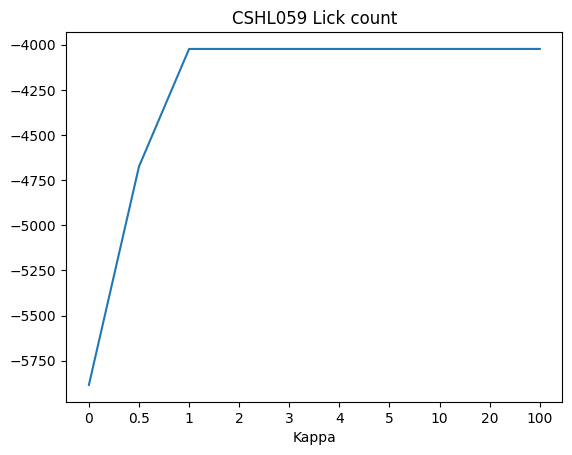

100


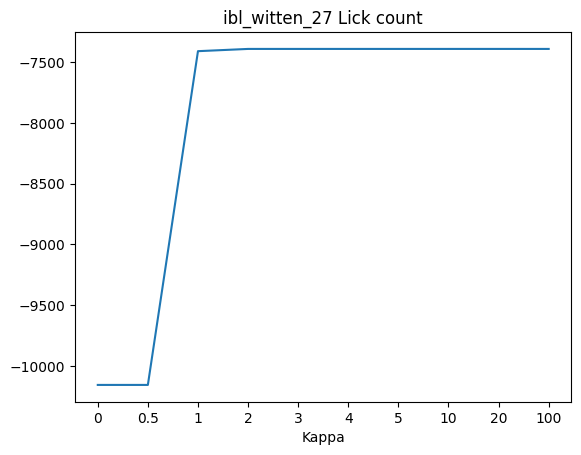

20


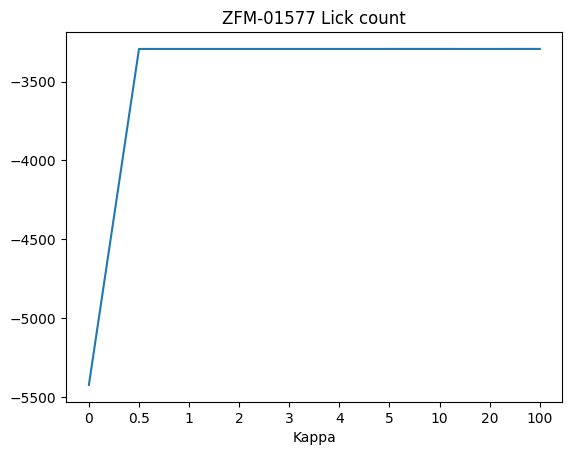

100


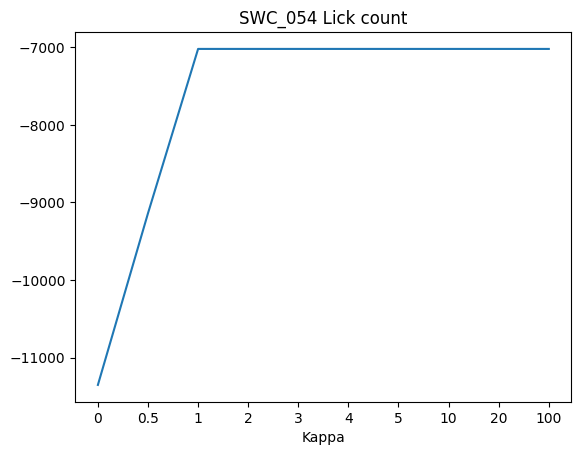

4


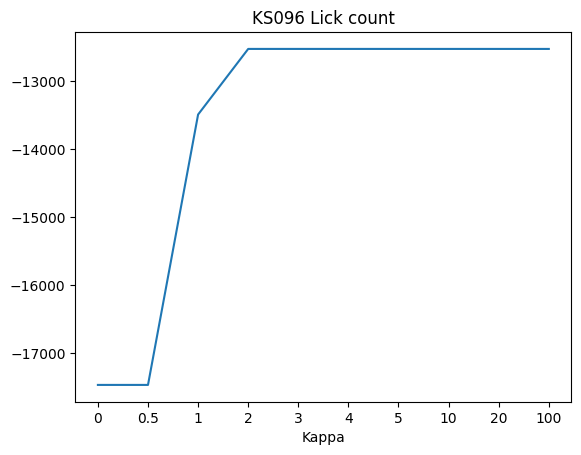

3


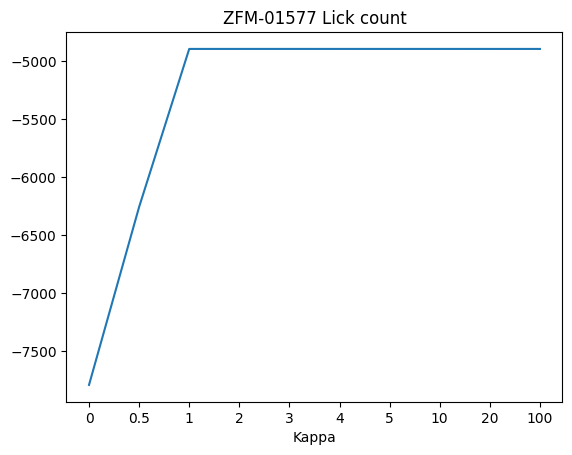

3


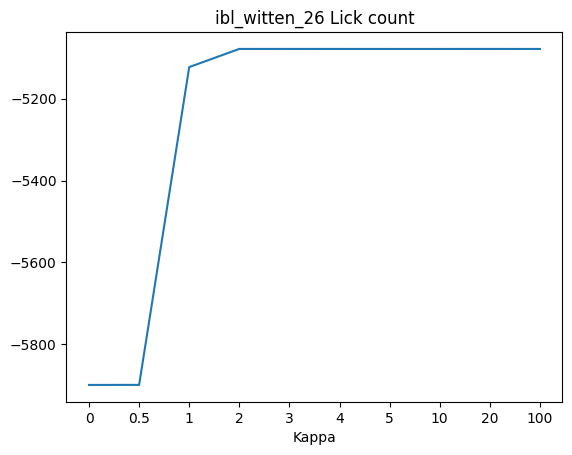

2


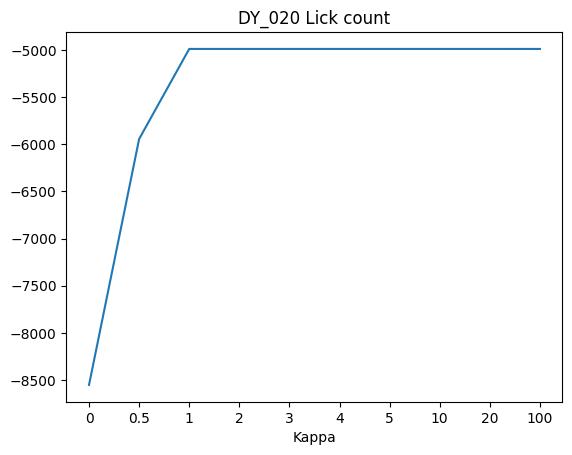

4


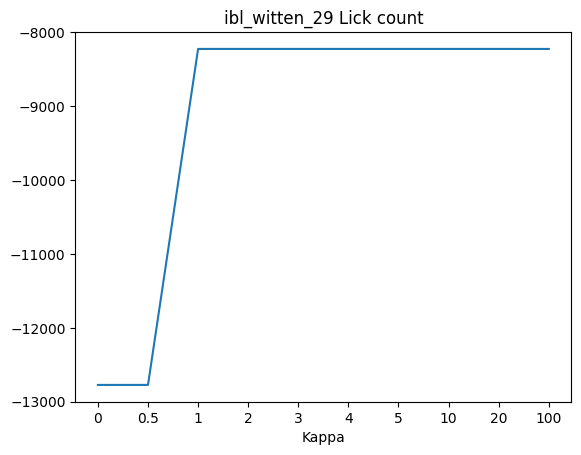

5


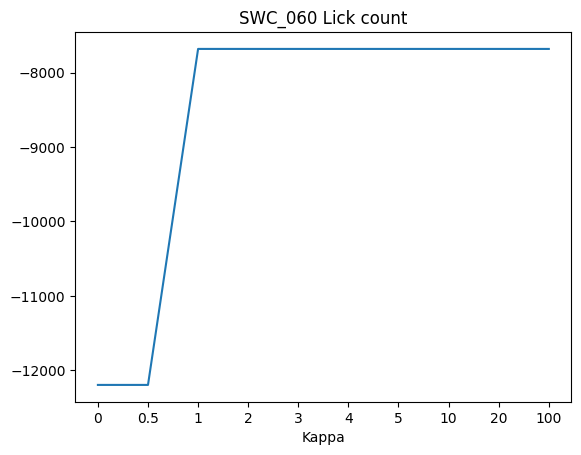

1


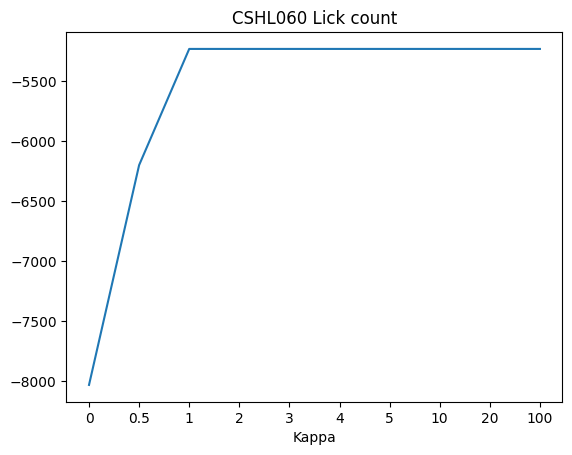

20


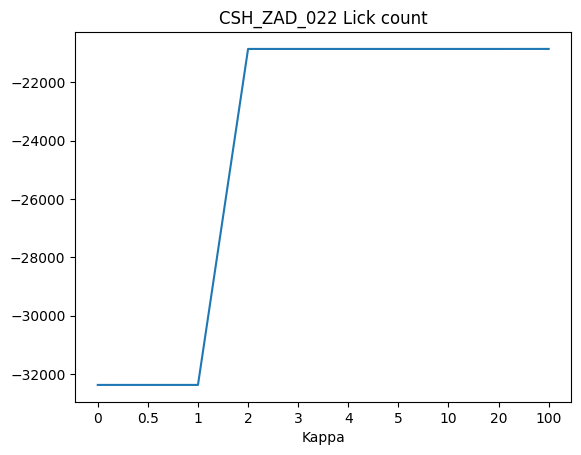

100


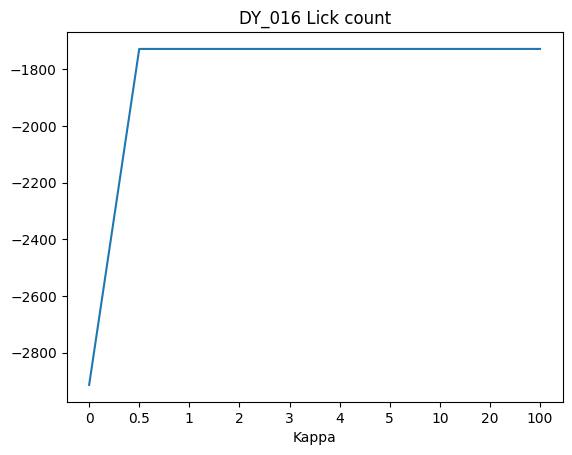

100


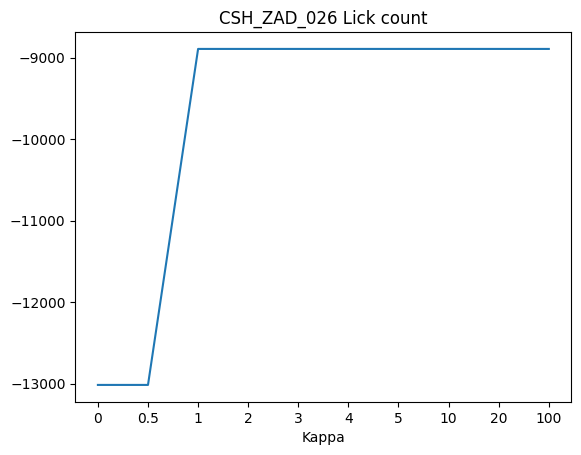

10


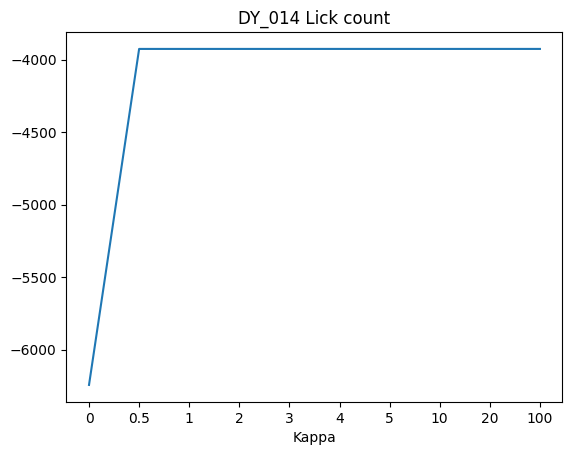

5


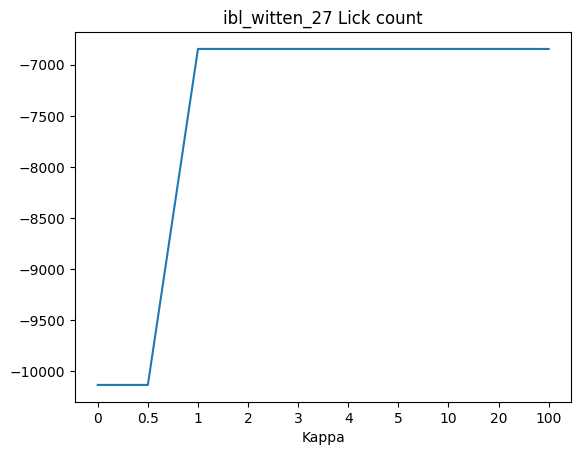

4


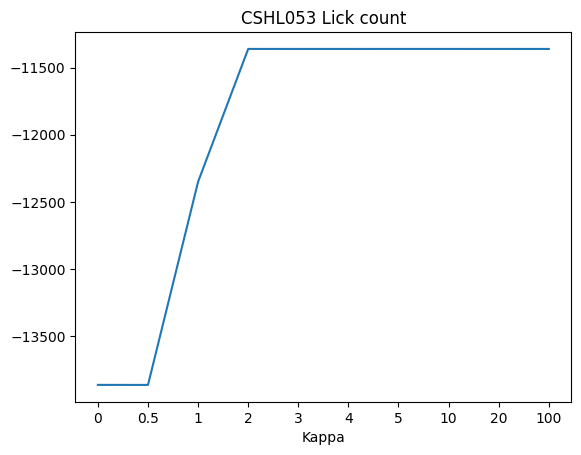

2


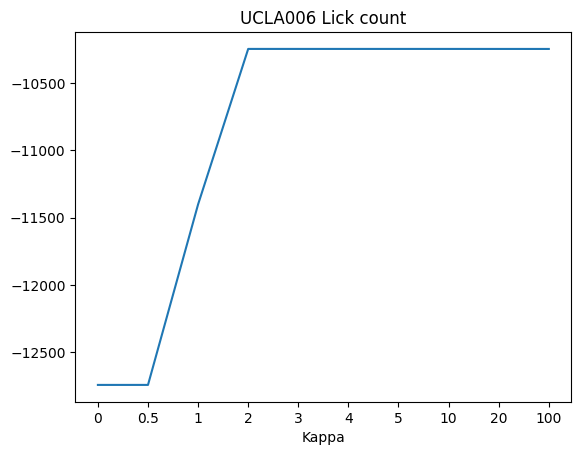

2


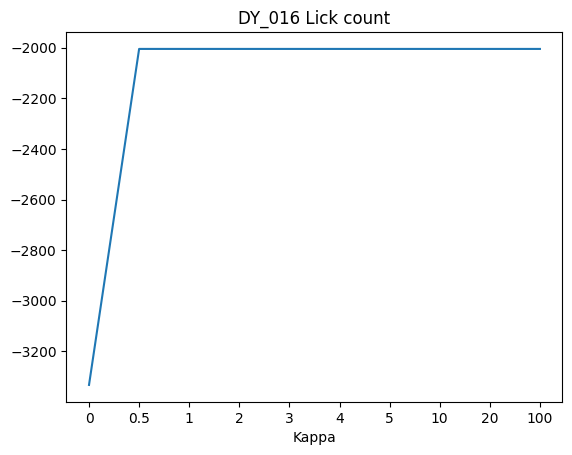

1


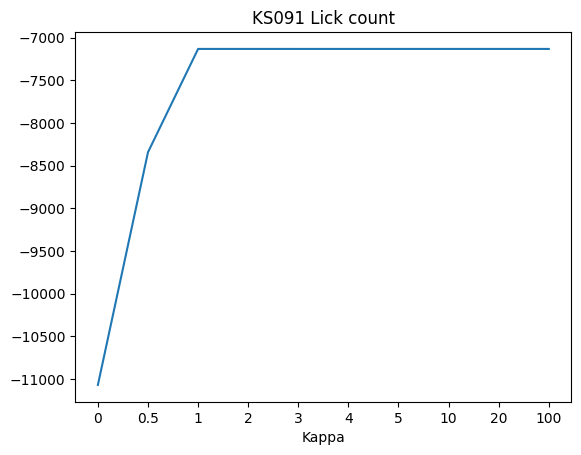

2


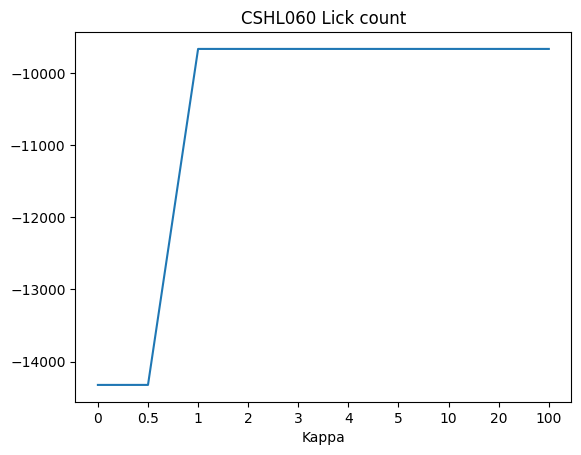

100


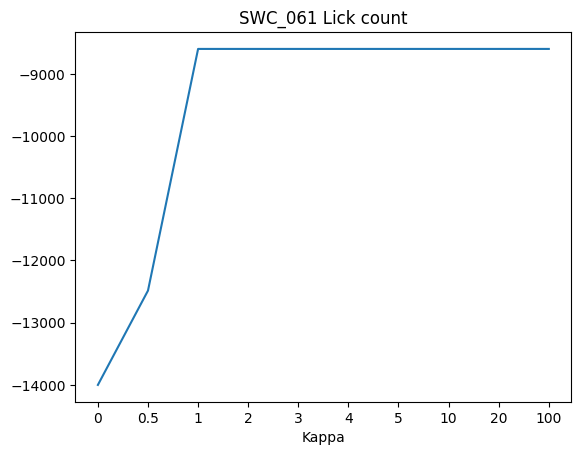

100


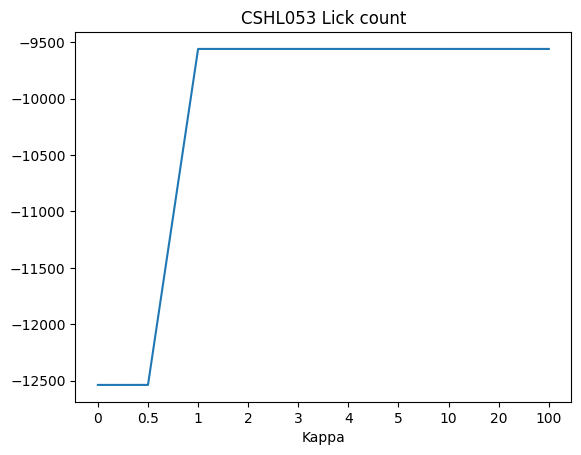

20


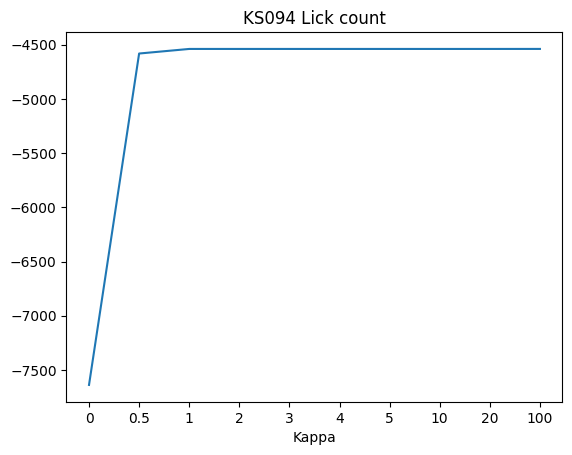

100


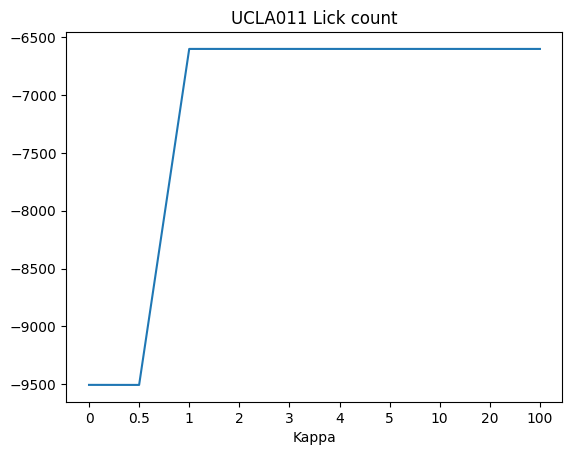

1


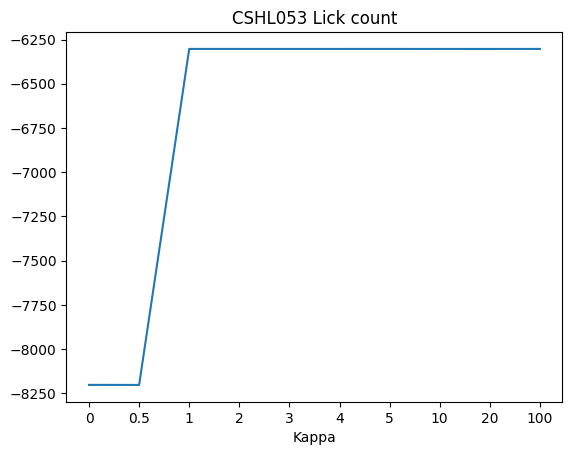

1


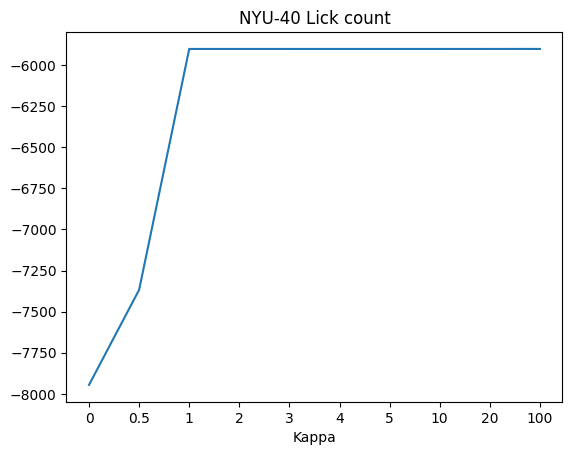

100


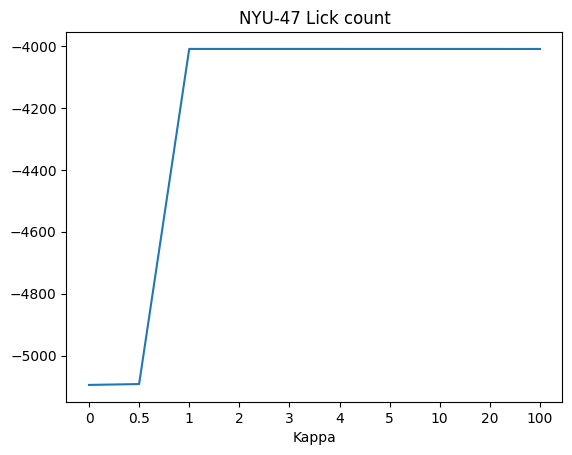

3


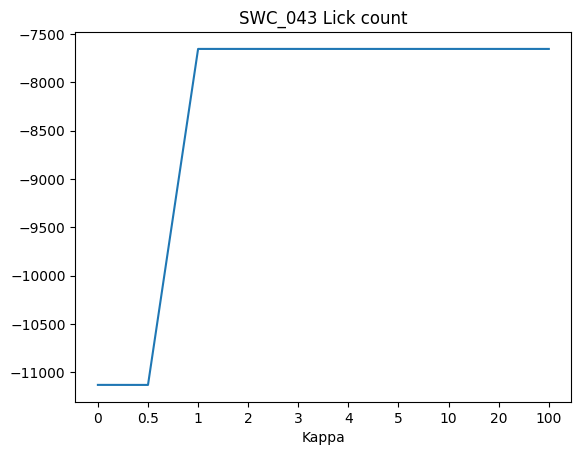

2


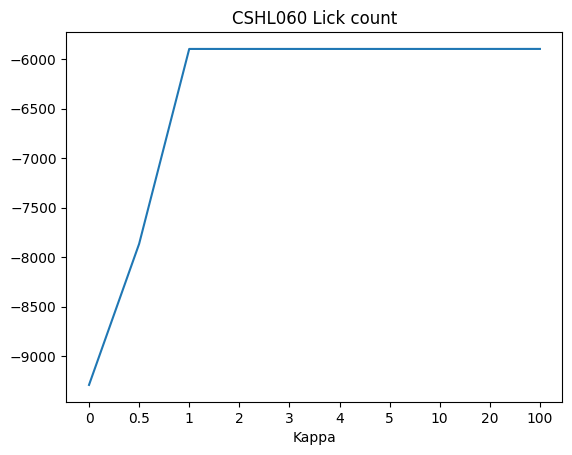

100


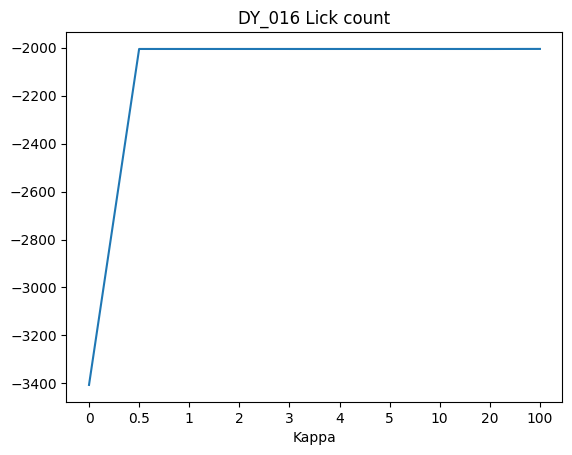

100


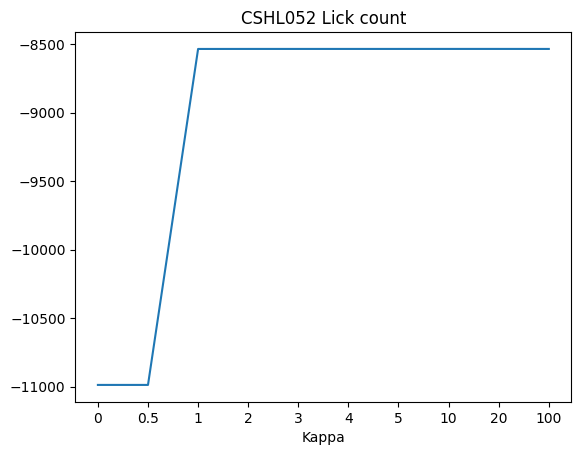

10


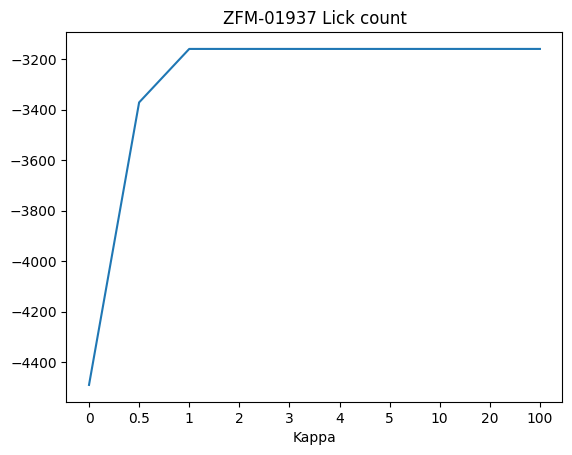

20


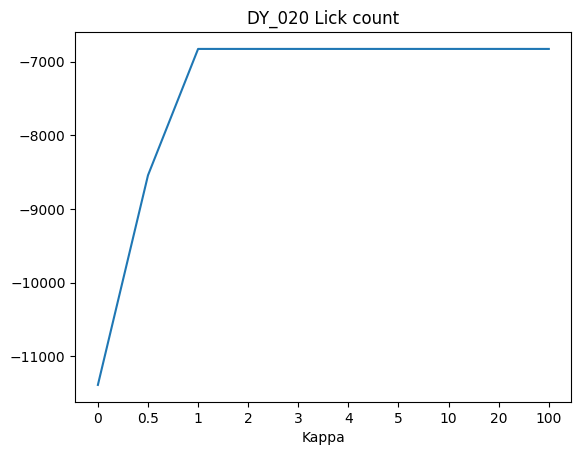

20


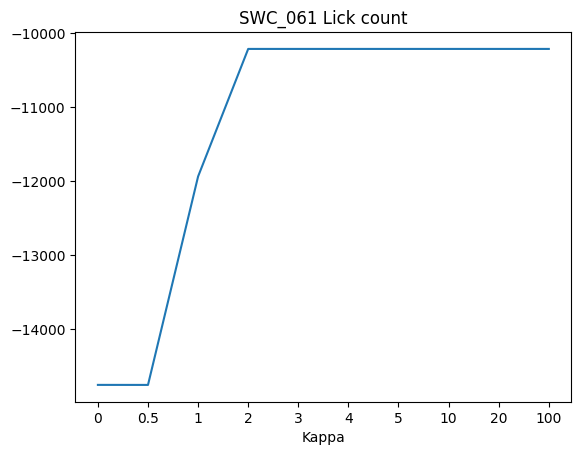

100


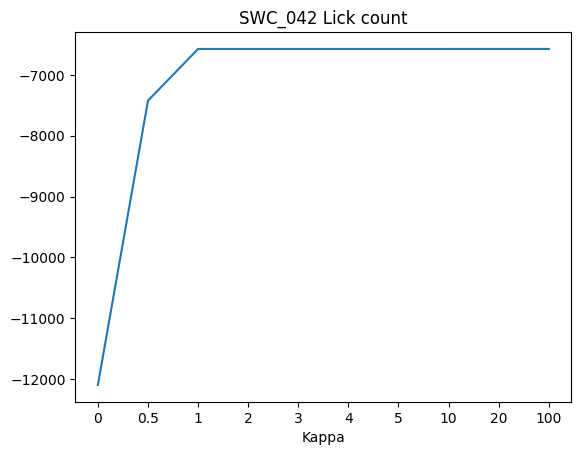

100


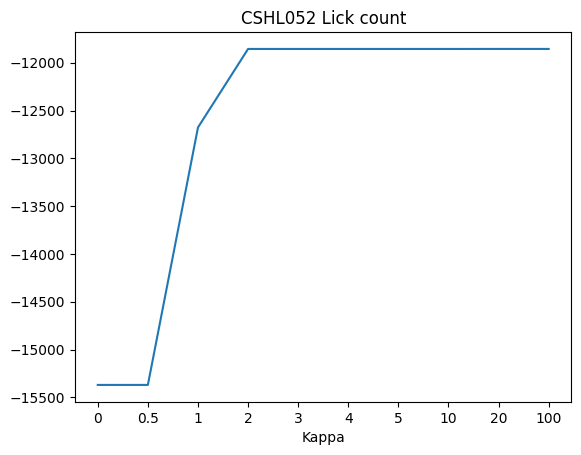

20


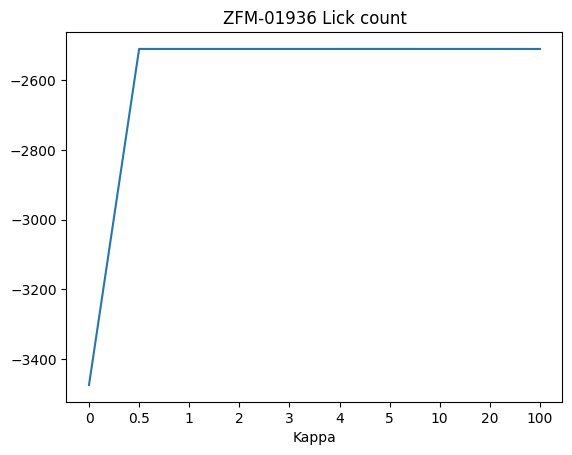

5


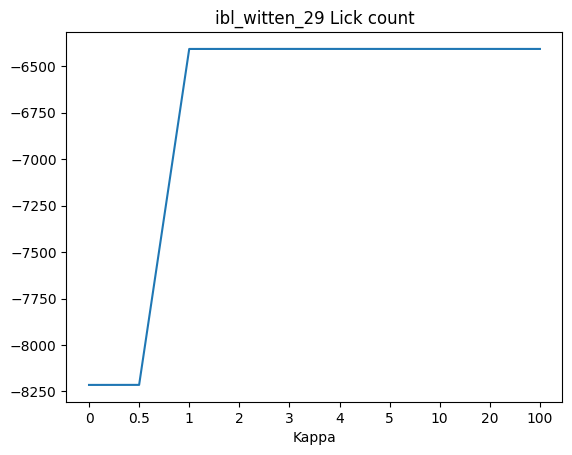

3


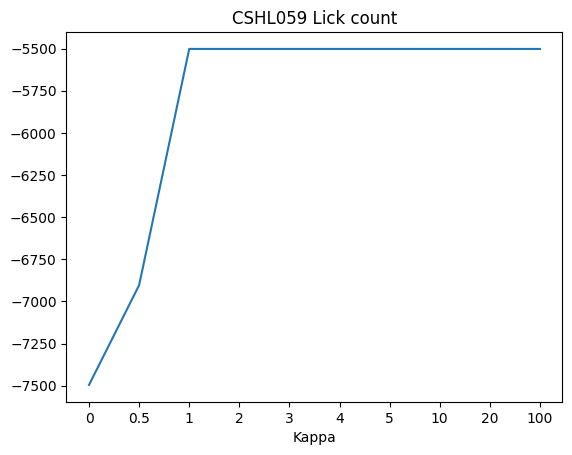

10


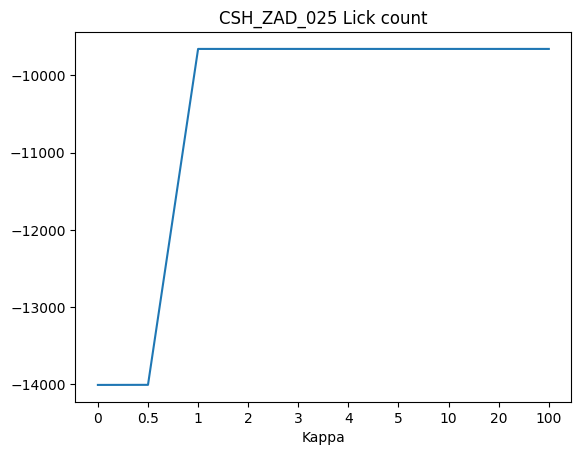

3


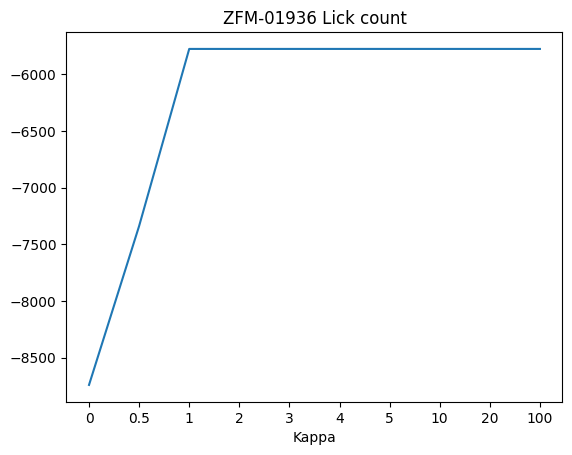

5


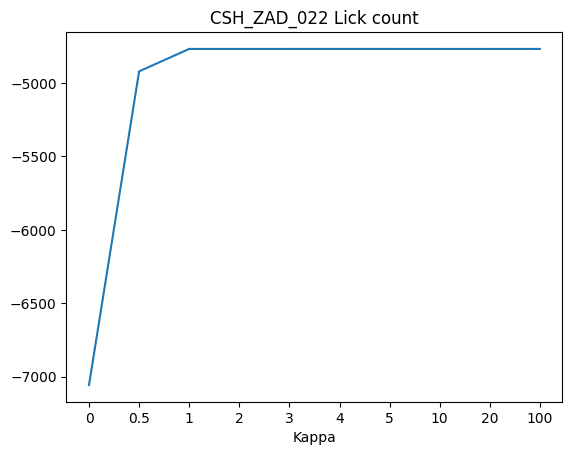

4


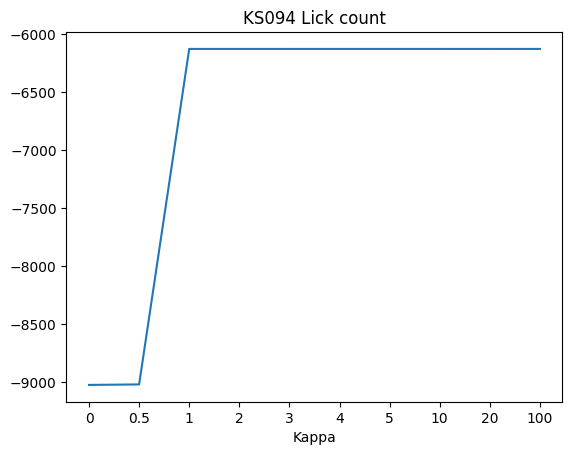

5


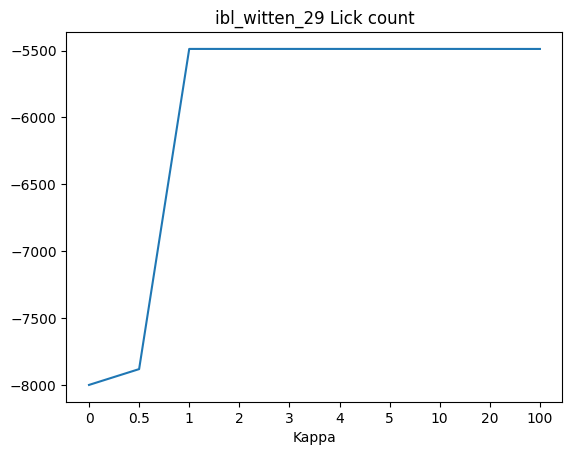

10


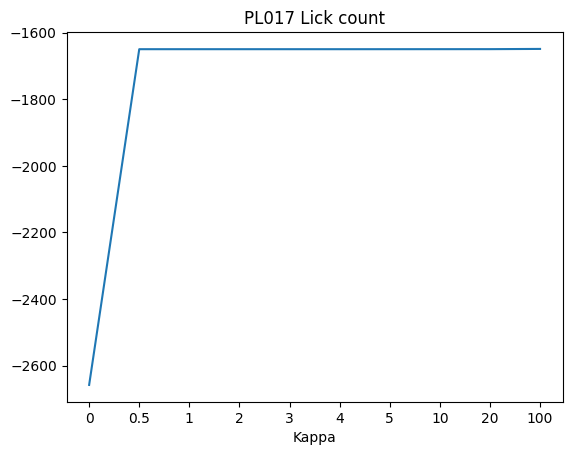

100


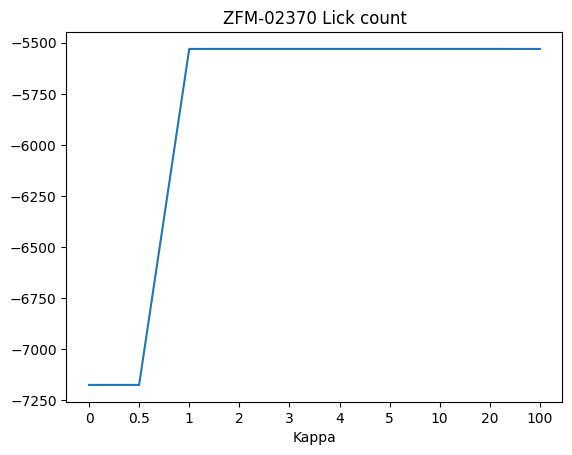

20


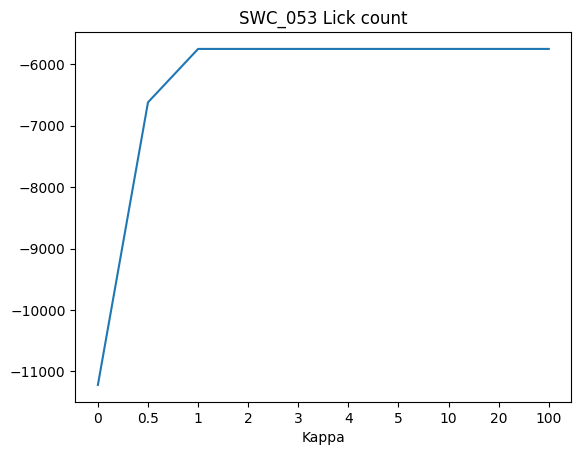

100


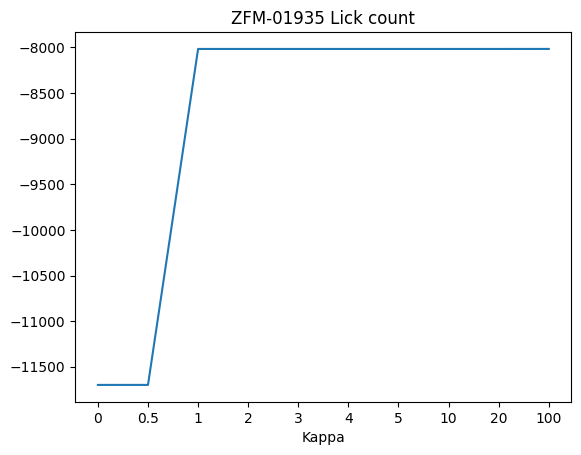

100


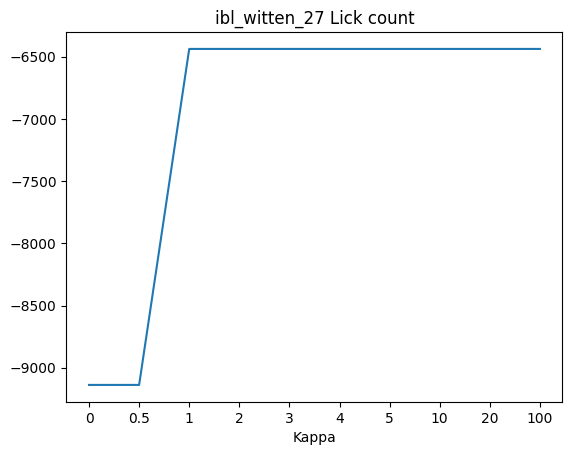

2


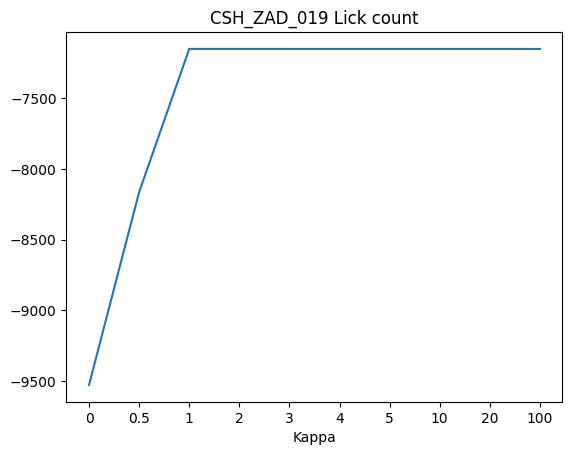

1


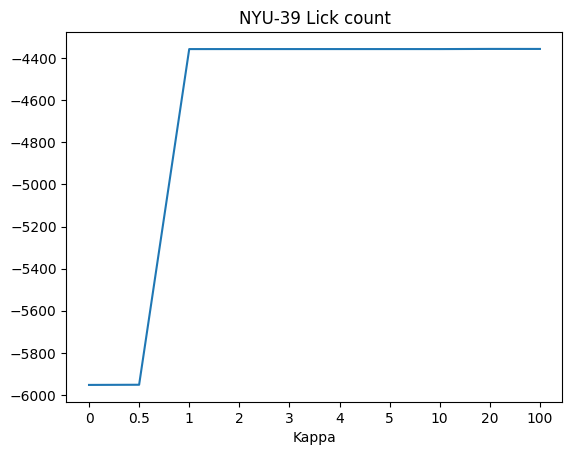

20


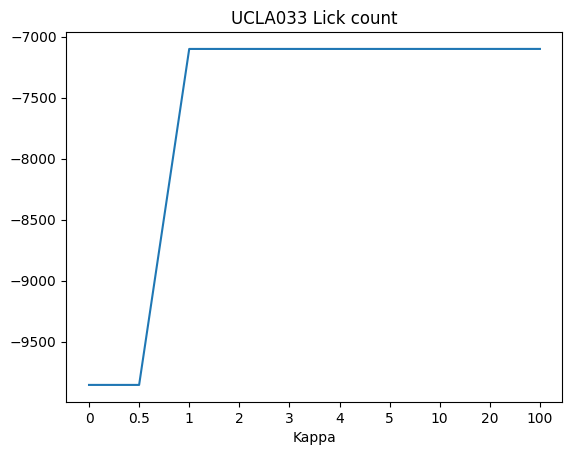

100


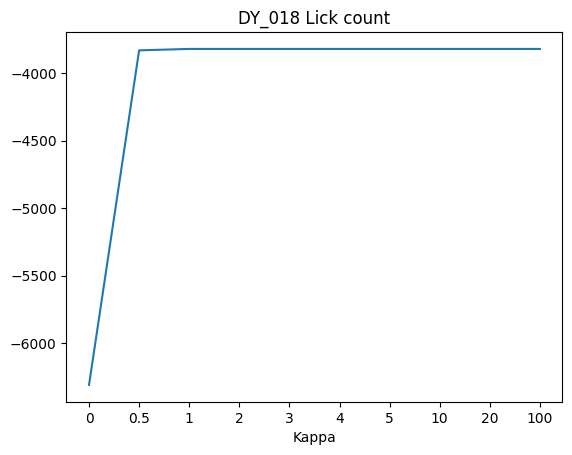

1


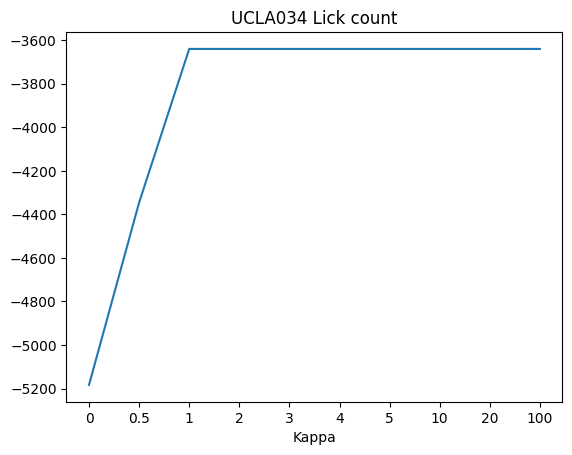

1


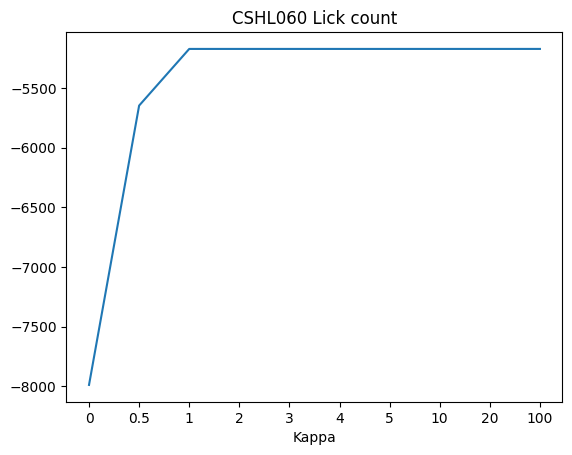

100


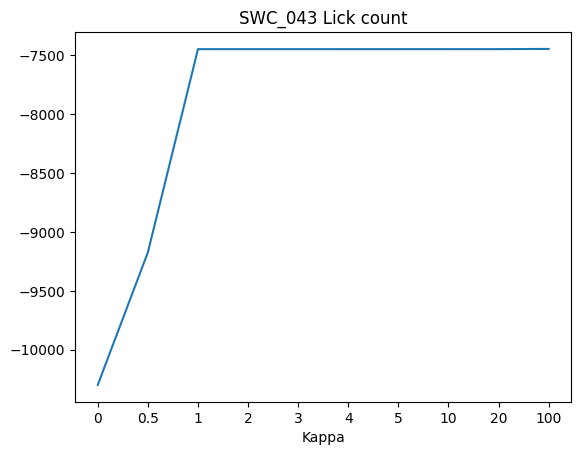

100


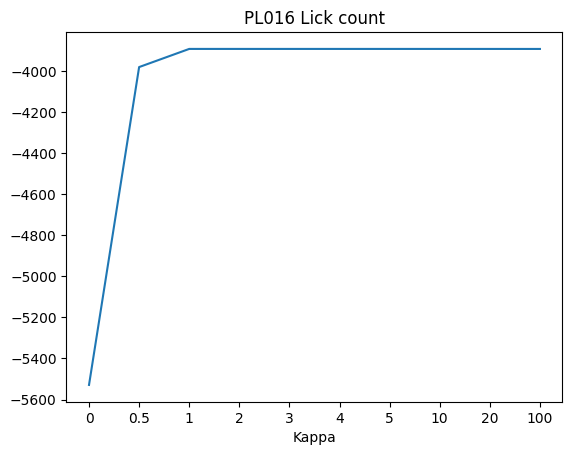

1


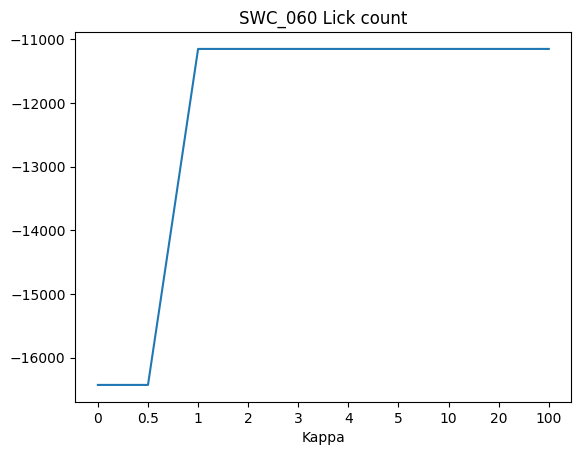

100


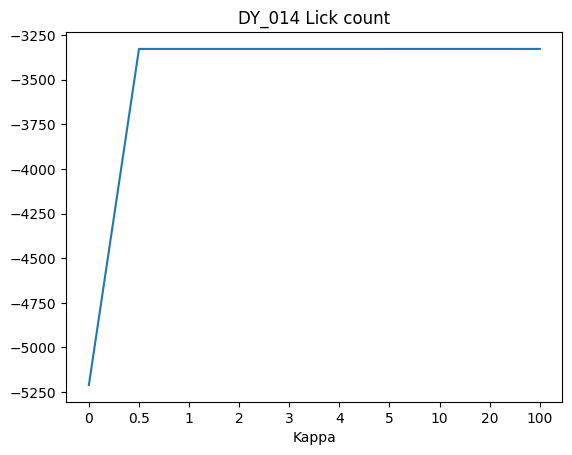

10


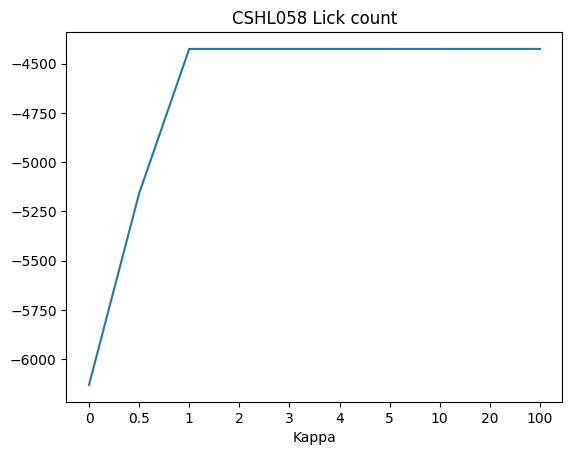

20


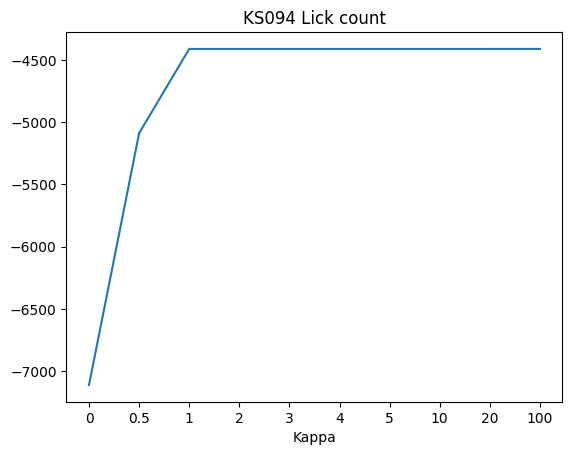

100


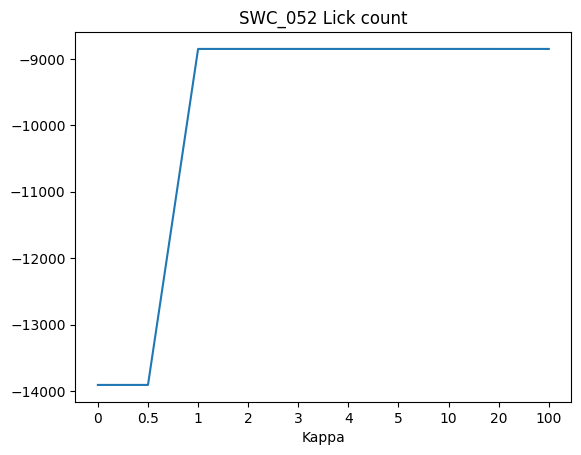

10


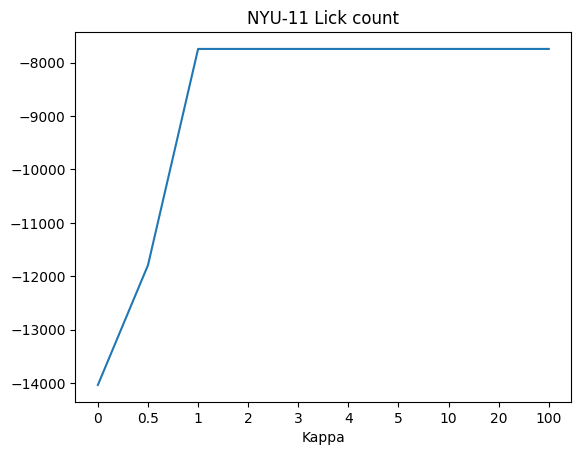

3


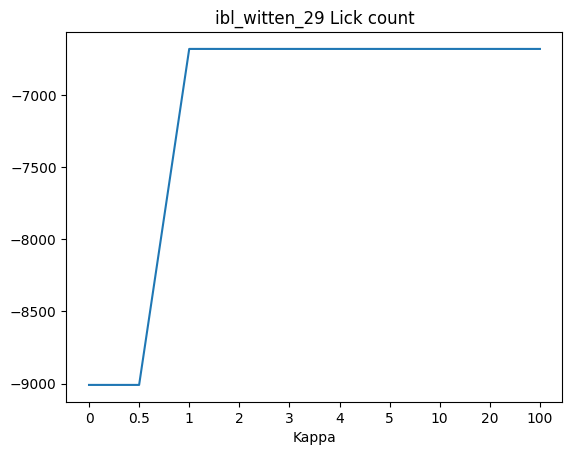

1


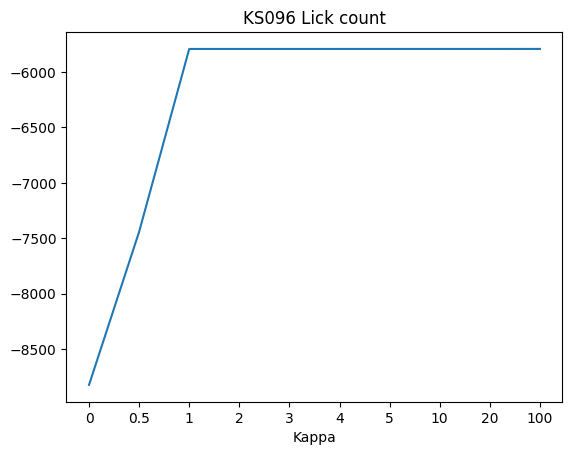

100


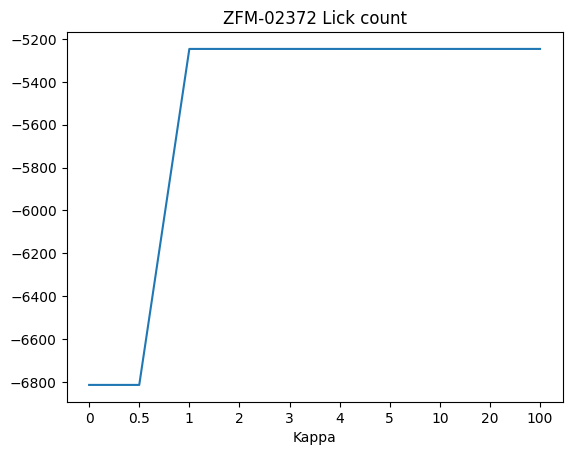

20


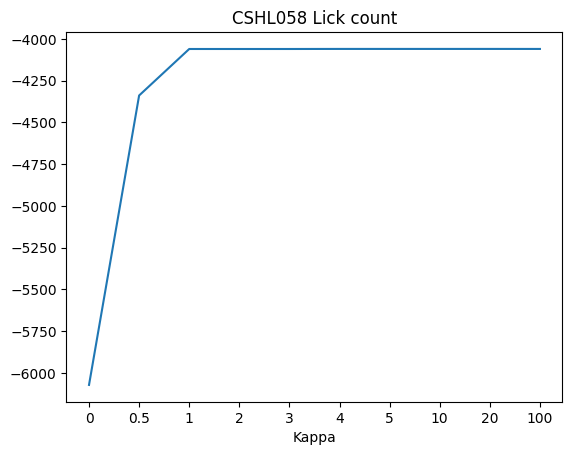

20


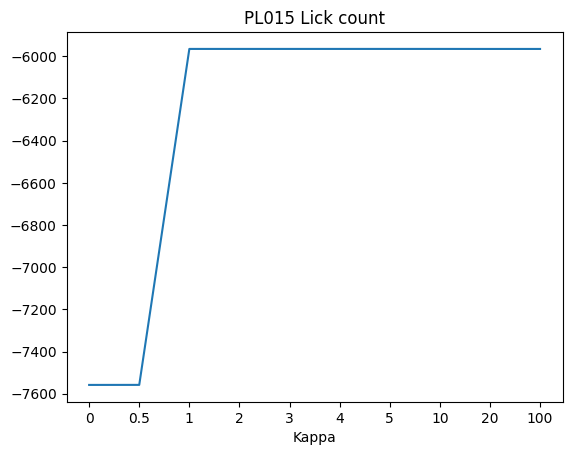

5


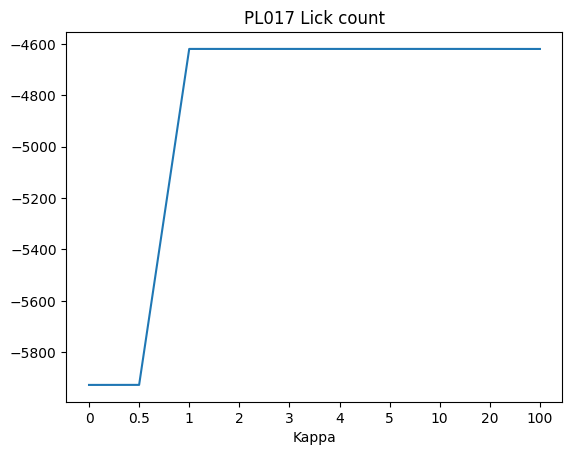

10


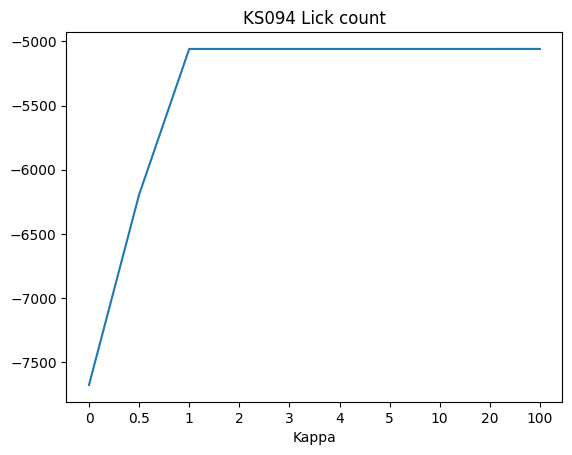

100


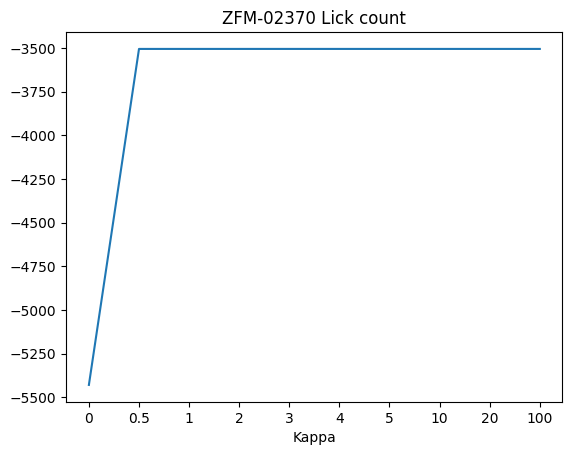

3


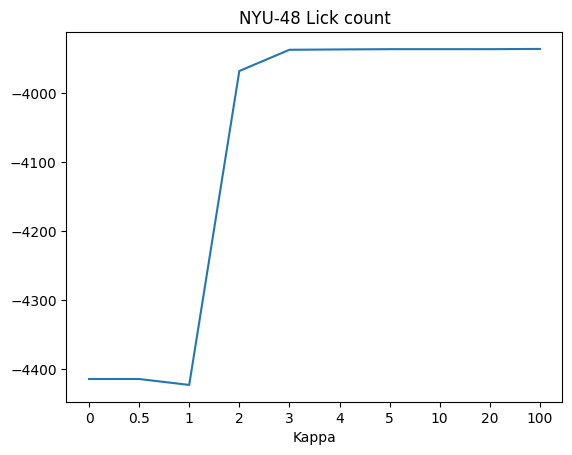

100


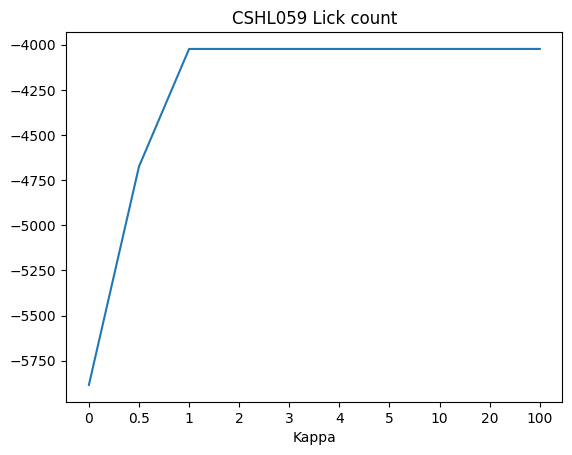

100


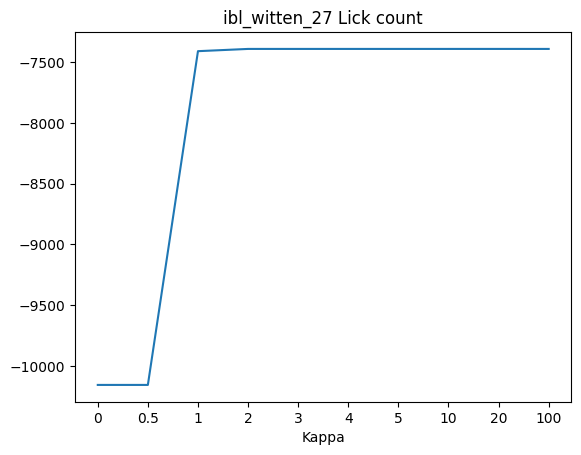

20


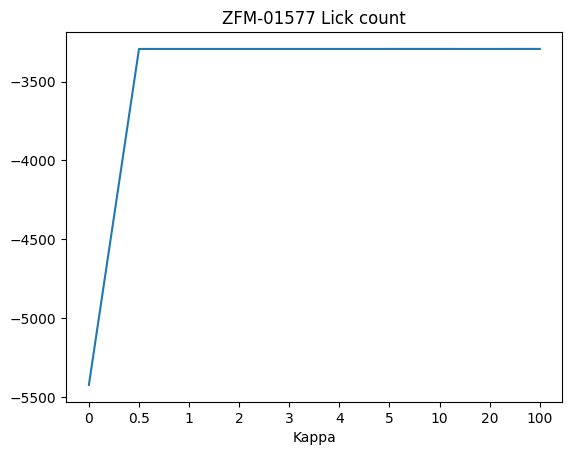

100


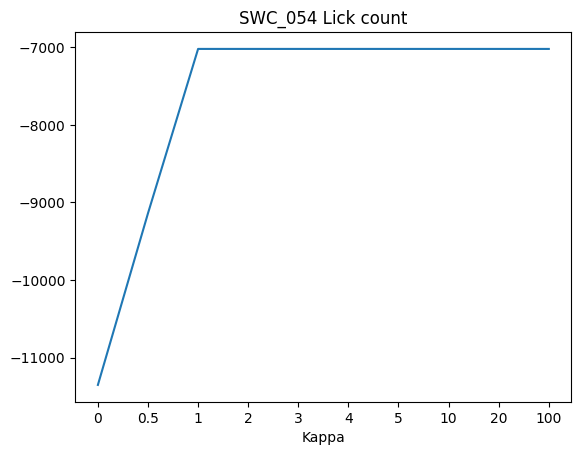

4


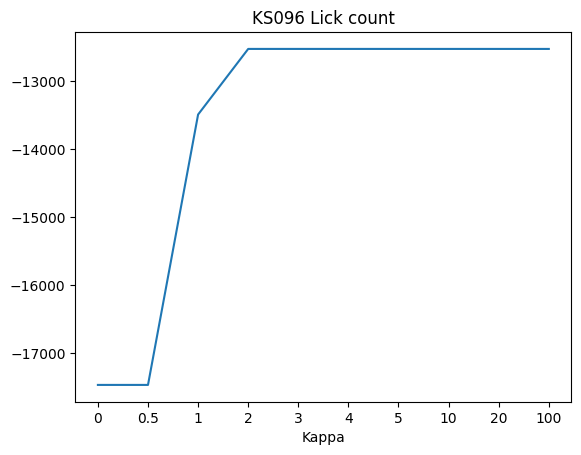

3


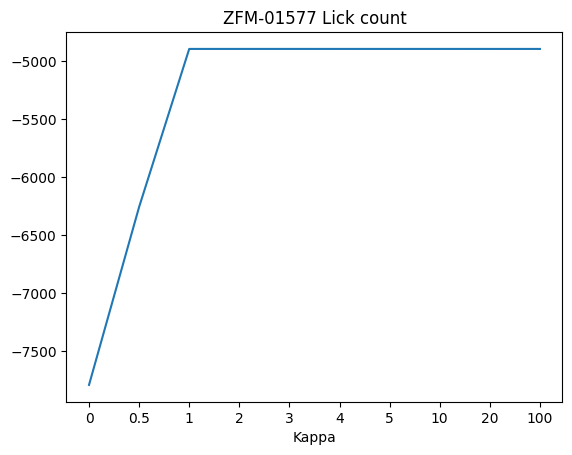

3


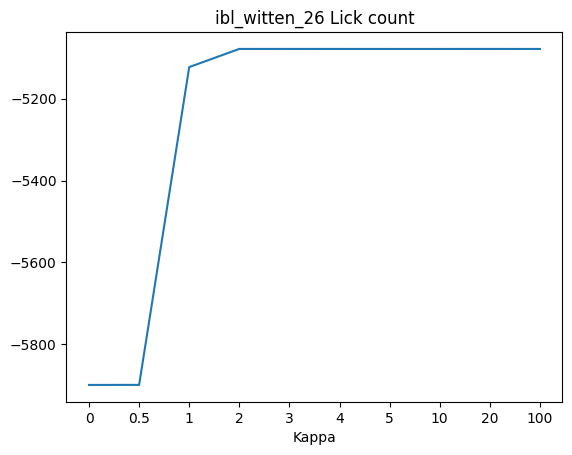

2


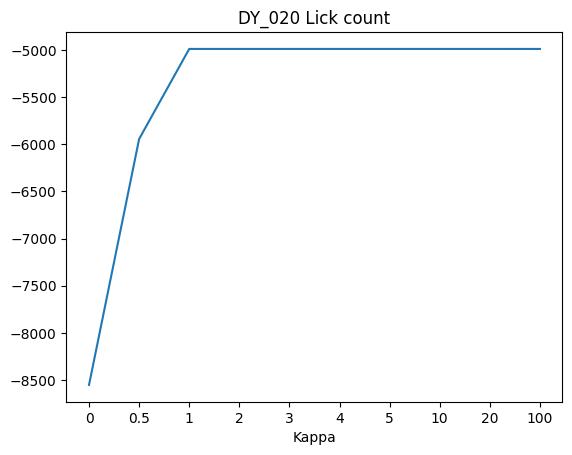

4


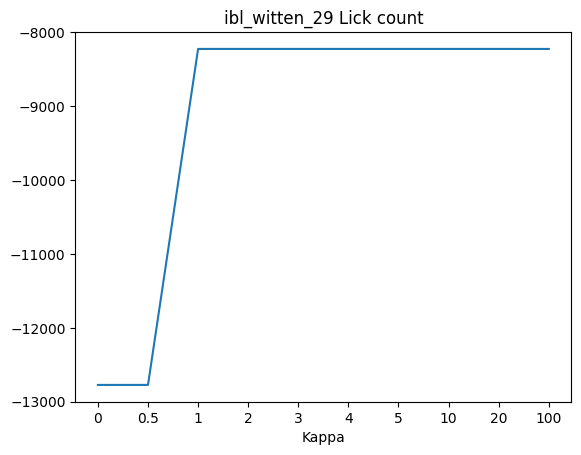

5


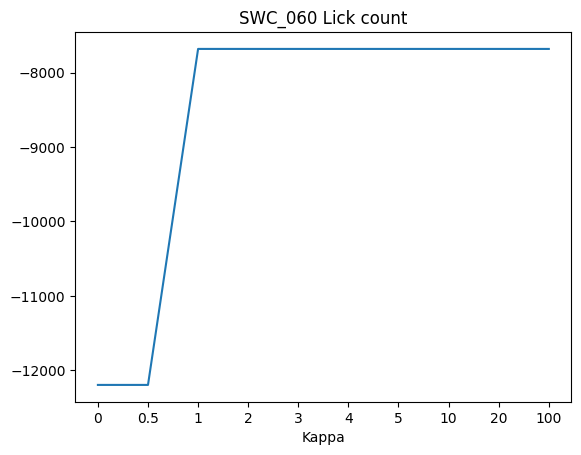

1


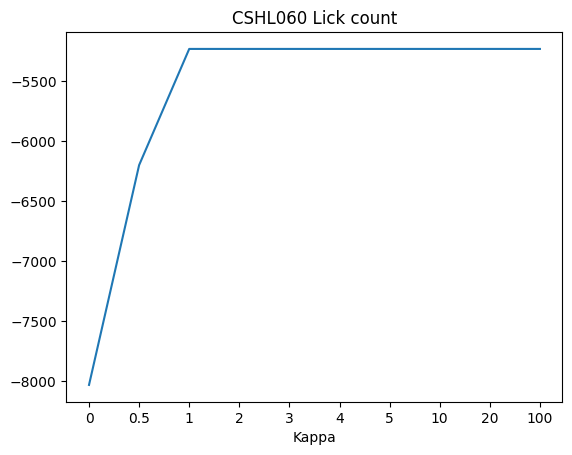

20


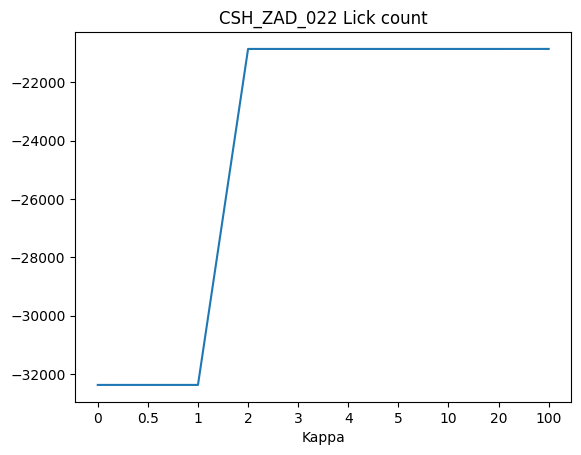

100


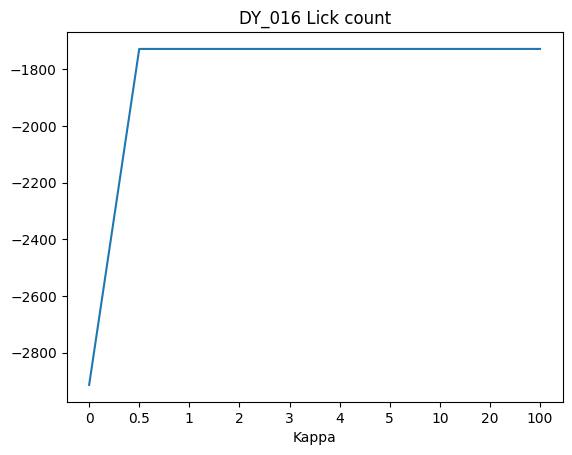

100


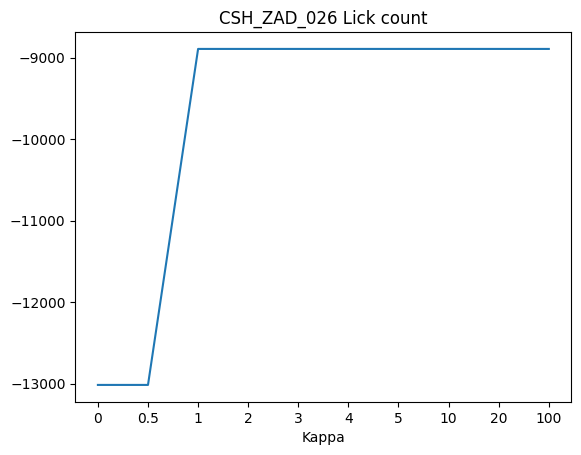

10


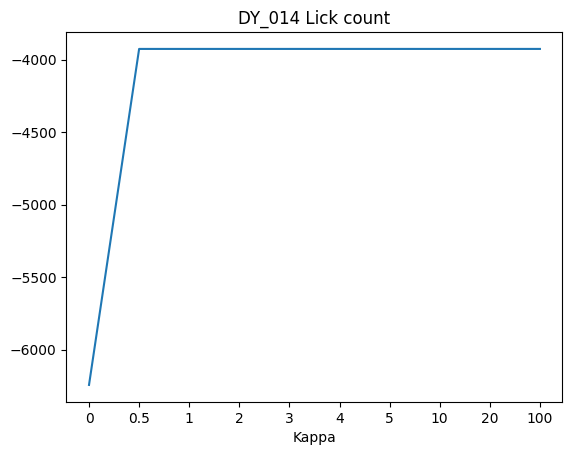

5


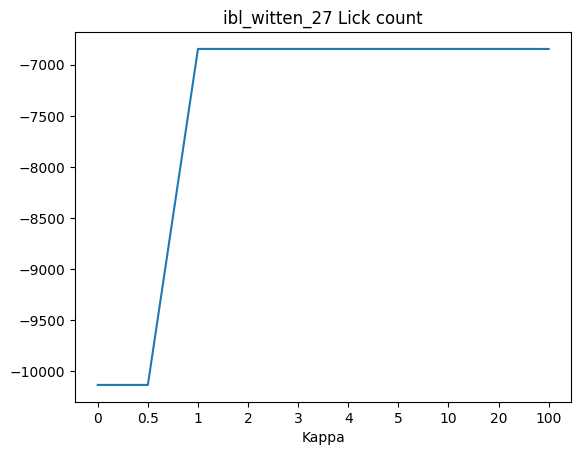

4


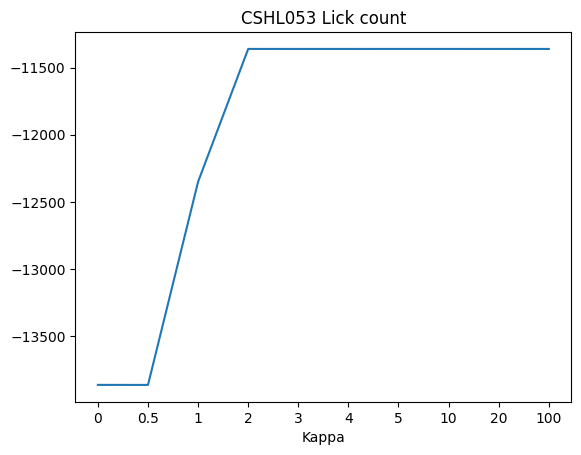

2


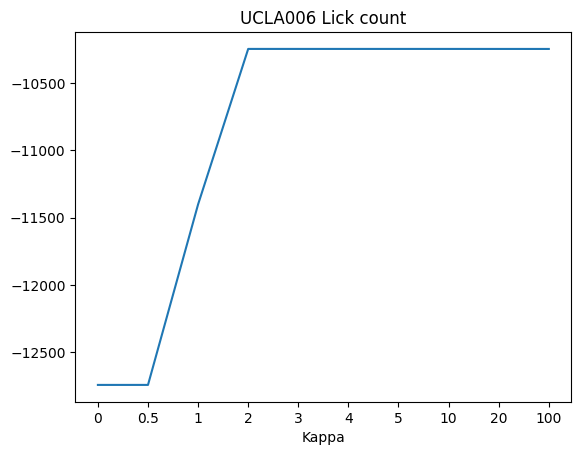

2


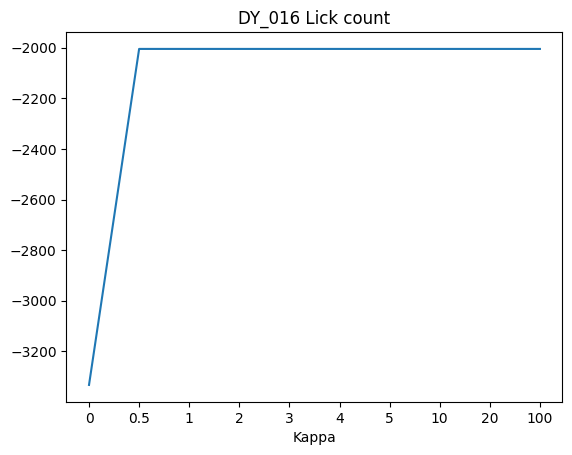

1


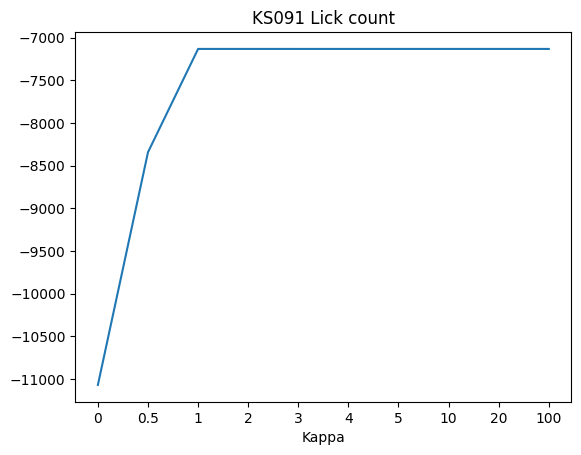

2


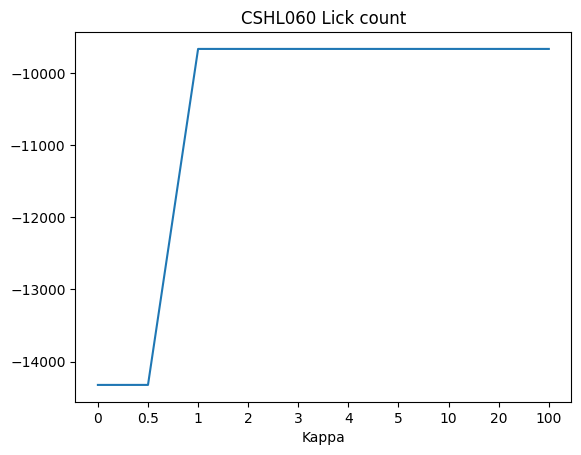

100


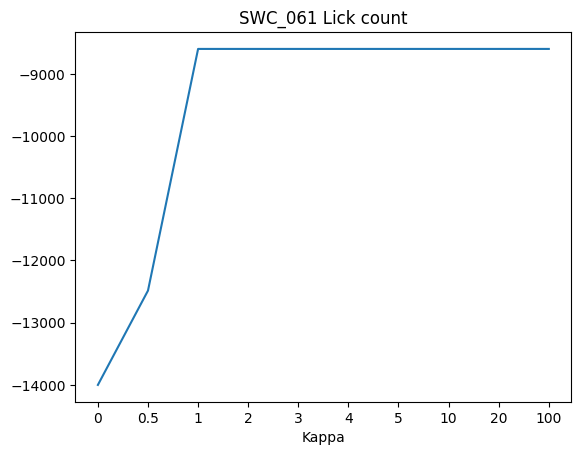

100


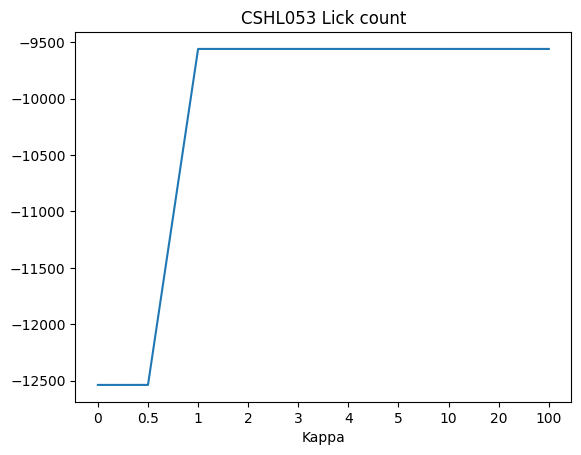

20


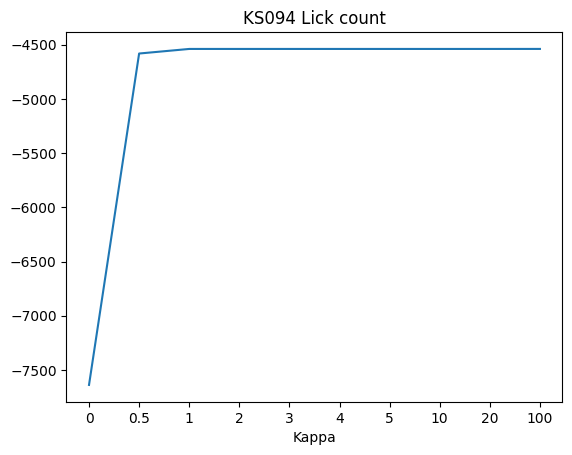

100


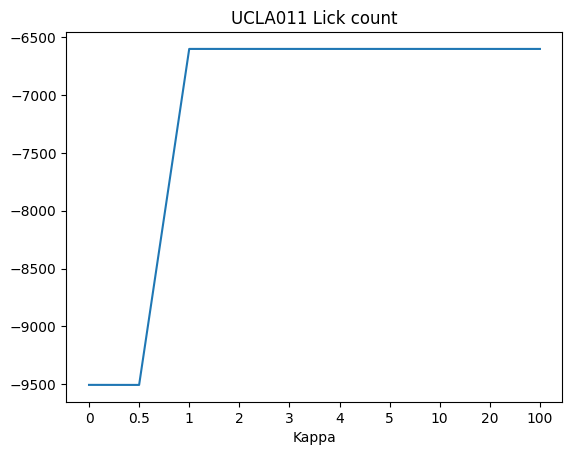

1


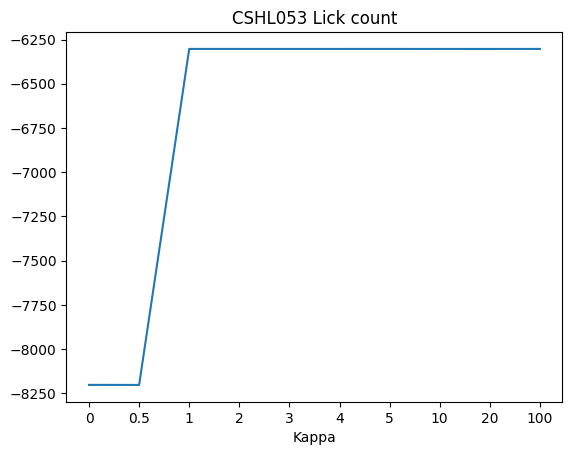

1


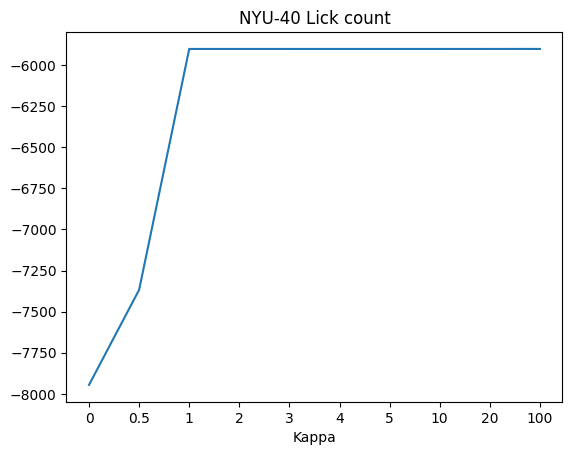

100


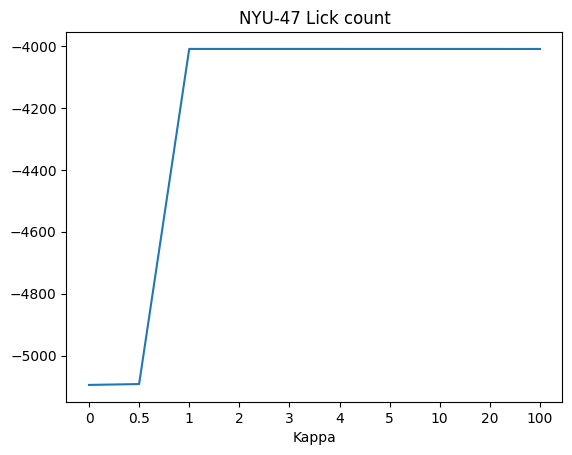

3


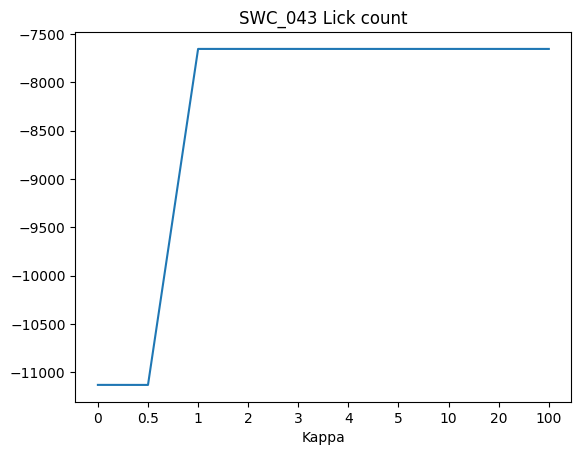

2


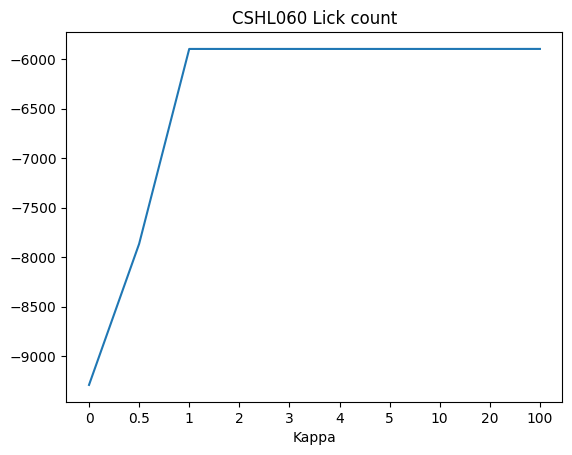

100


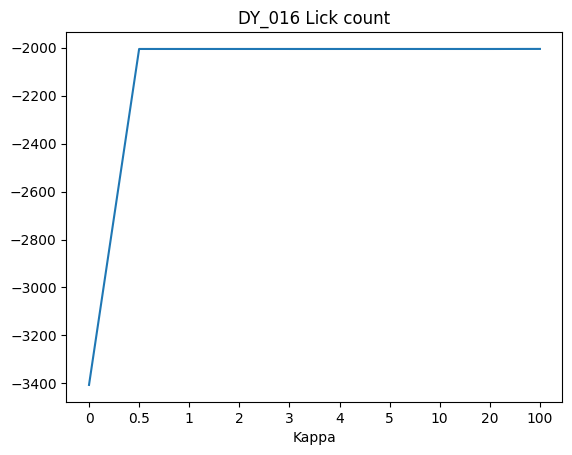

100


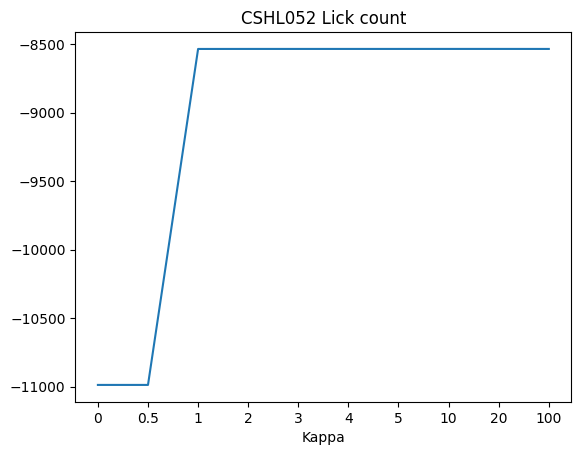

10


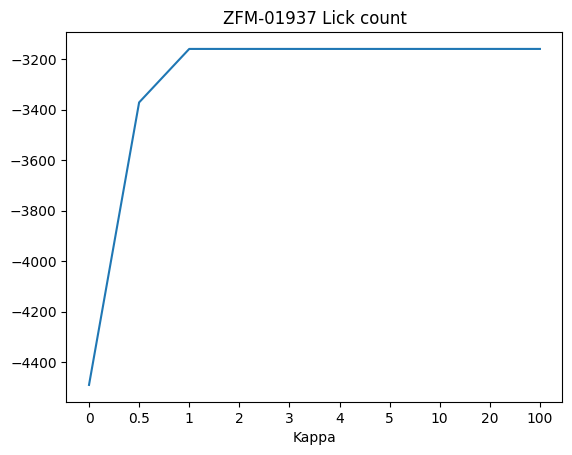

20


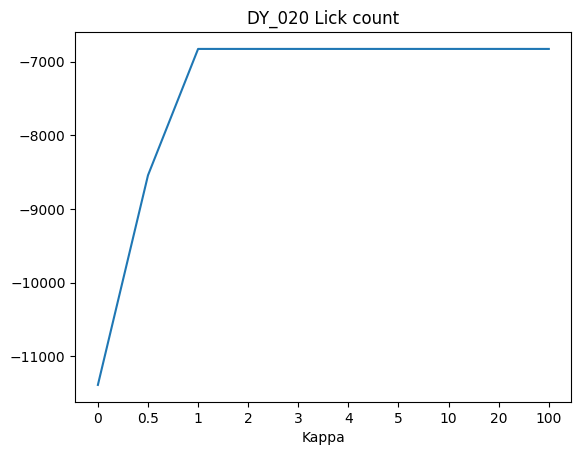

20


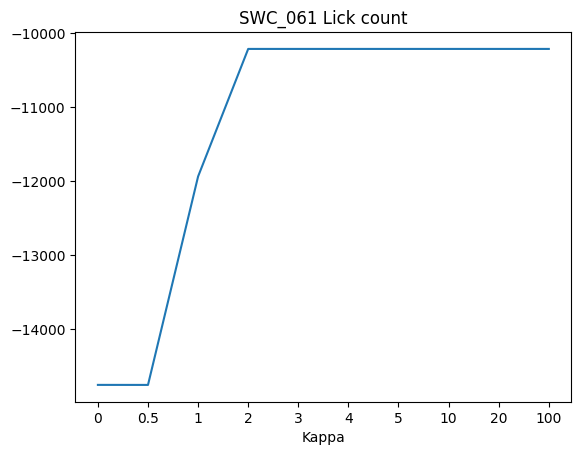

100


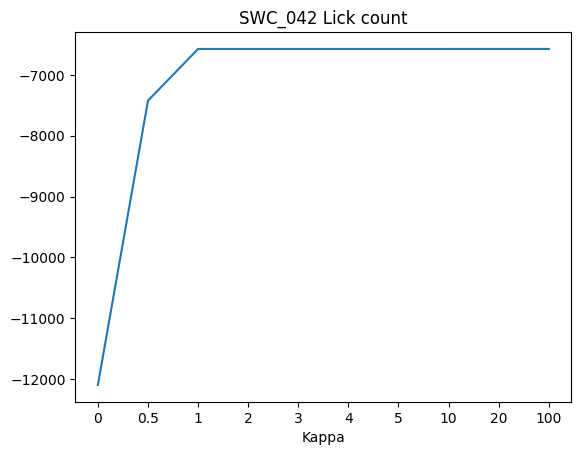

100


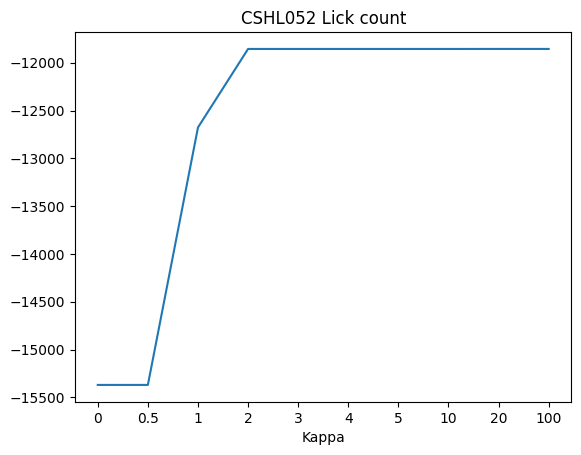

20


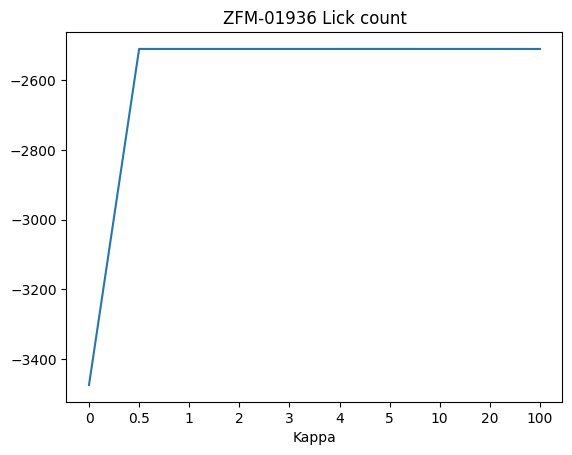

5


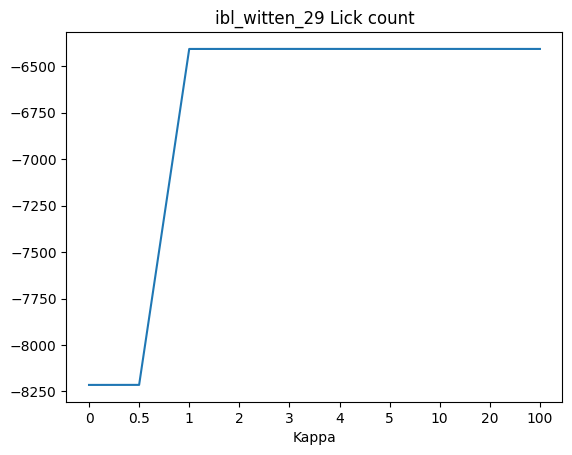

3


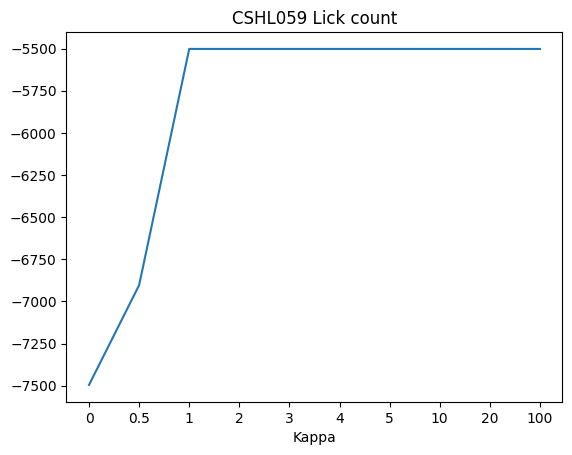

10


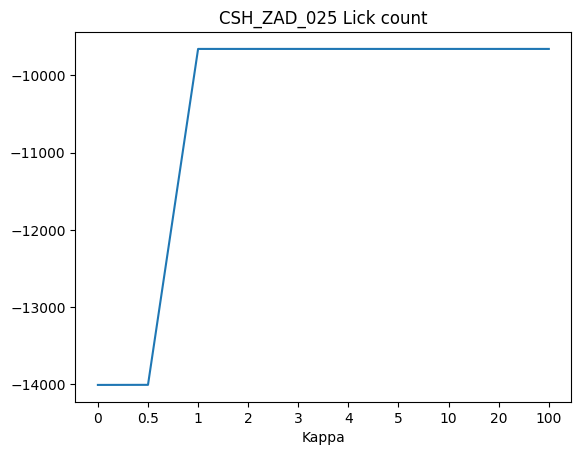

3


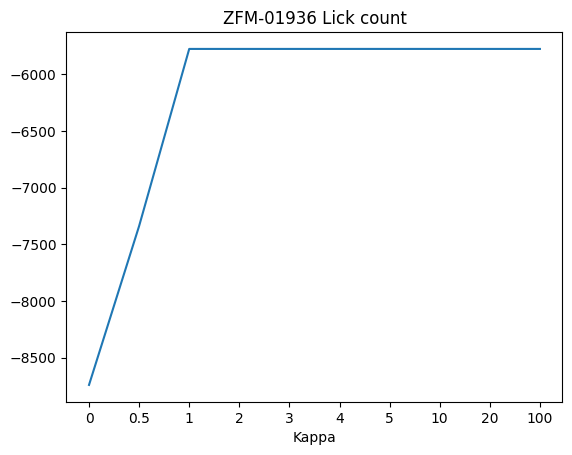

5


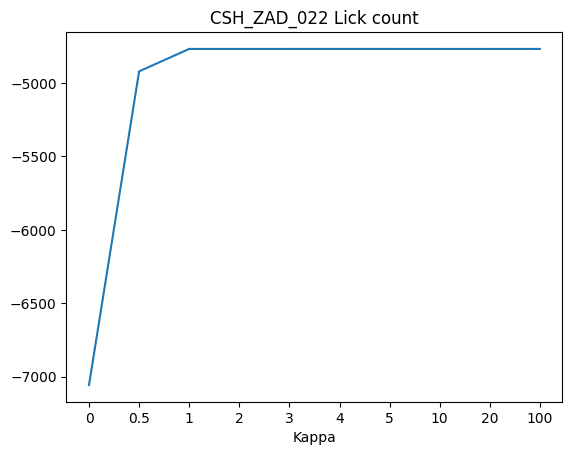

4


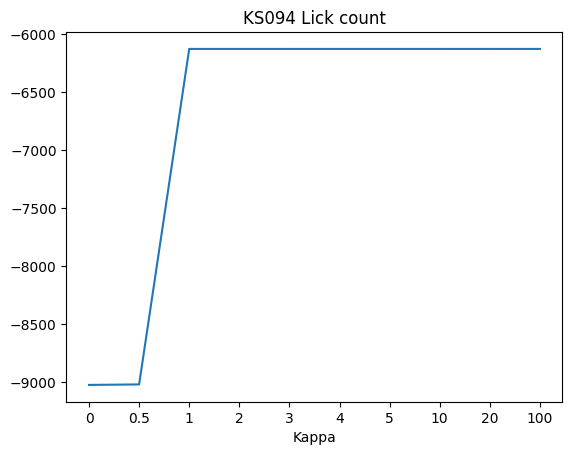

5


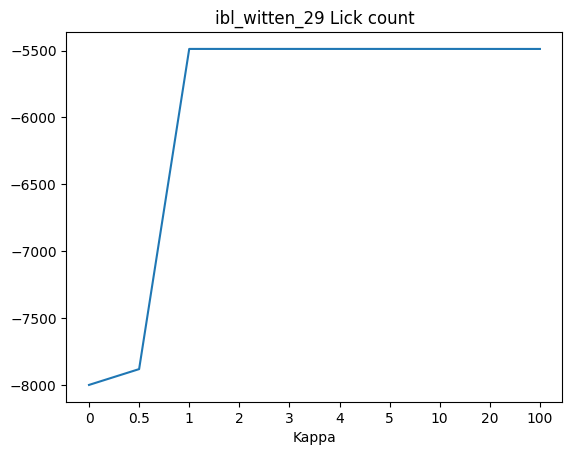

10


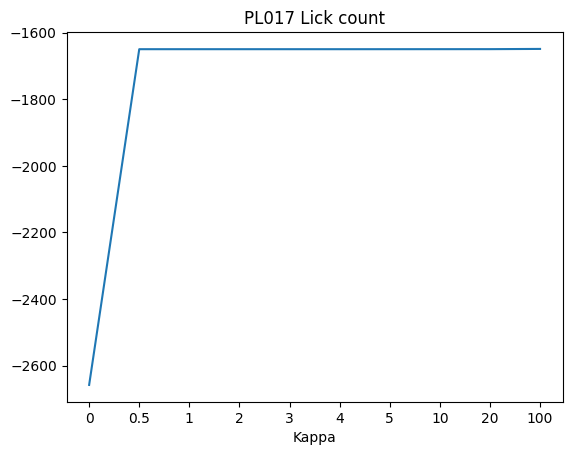

100


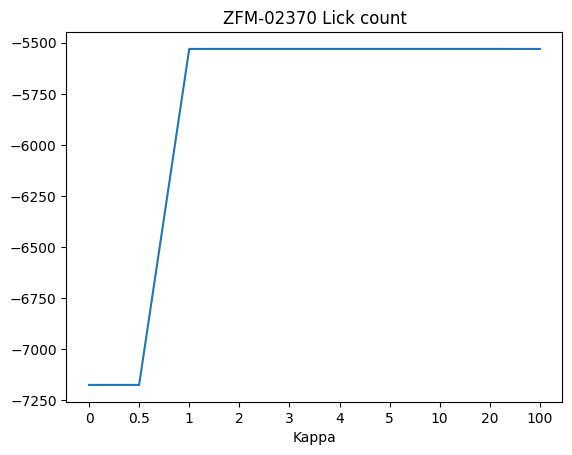

20


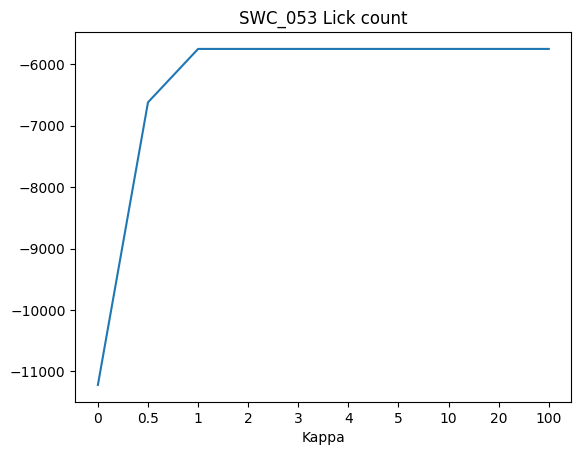

100


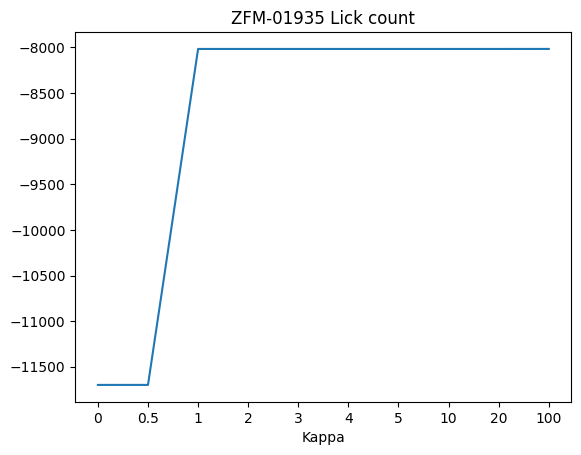

100


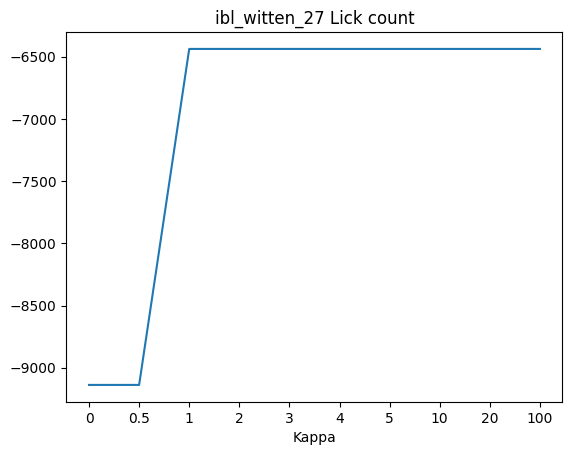

2


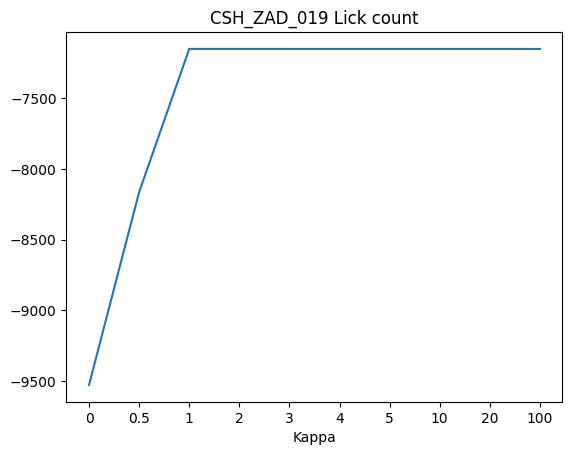

1


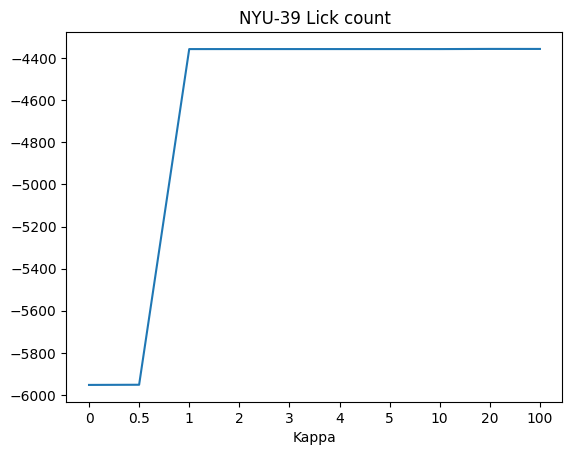

20


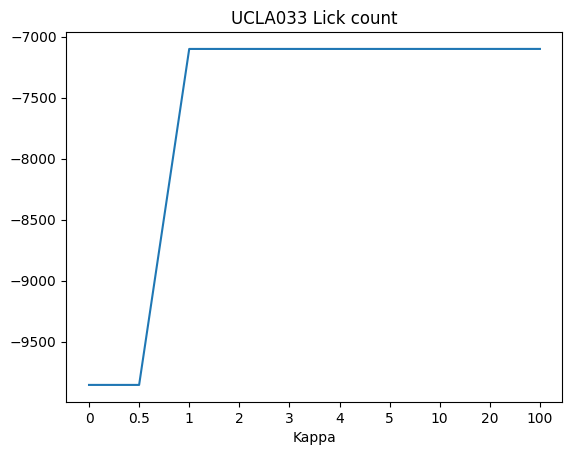

100


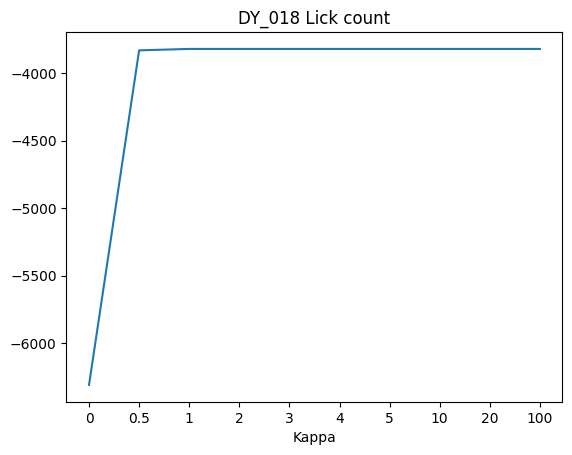

1


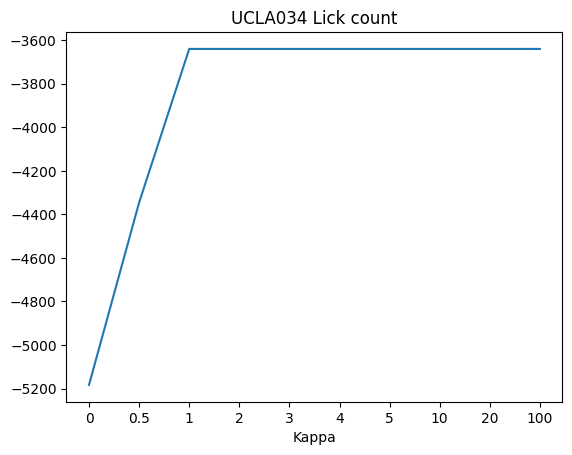

1


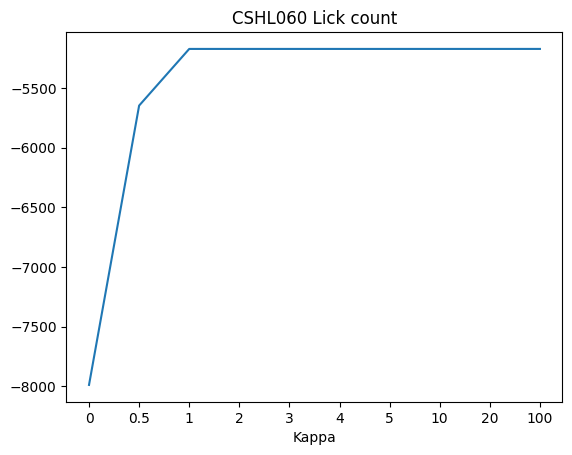

100


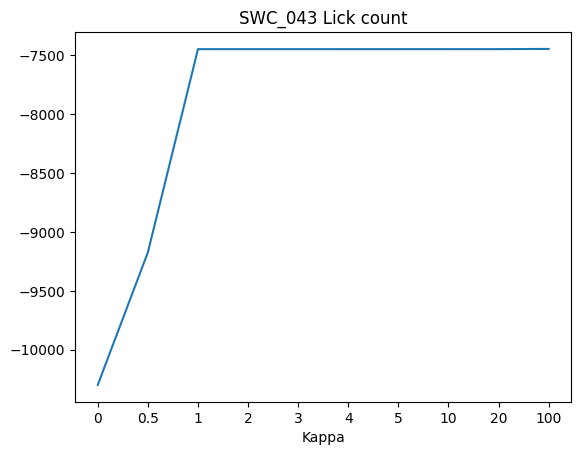

100


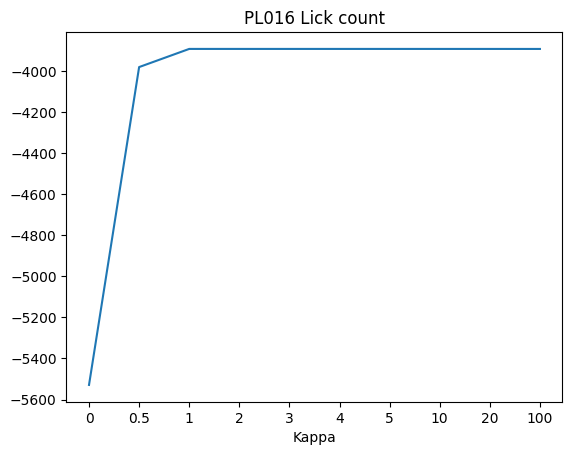

1


In [9]:
for s, var_interest in enumerate(var_interest_map[:2]):
    s = 1
    var_interest = 'Lick count'
    # var_interest = 'avg_wheel_vel'
    
    index_var = np.where(np.array(var_interest_map)==var_interest)[0][0]
    idx_init = idx_init_list[index_var]
    idx_end = idx_end_list[index_var]
    var_names = use_sets[index_var]

    for m, mat in enumerate(sessions_to_process):
            
        mouse_name = mat[0]
        session = mat[1]
        # mouse_name = 'PL017'
        # mouse_name = 'NYU-11'
        # session = '1b61b7f2-a599-4e40-abd6-3e758d2c9e25'
        # session = '56956777-dca5-468c-87cb-78150432cc57'
        fit_id = str(mouse_name+session)

        # Get mouse data
        data_file = data_path + "standardized_design_matrix_" + str(session) + '_'  + mouse_name
        standardized_designmatrix = np.load(data_file+str('.npy'))
        # Need to dropnans
        filtered_matrix = standardized_designmatrix[~np.isnan(standardized_designmatrix).any(axis=1)]
        design_matrix = filtered_matrix[:, idx_init:idx_end]
        # design_matrix = matrix_all[mouse_name][session][:,idx_init:idx_end]

        # Prepare data
        num_timesteps = np.shape(design_matrix)[0]
        emission_dim = np.shape(design_matrix)[1]
        shortened_array = np.array(design_matrix[:(num_timesteps // num_train_batches) * num_train_batches])
        train_emissions = jnp.stack(jnp.split(shortened_array, num_train_batches))

        results_file = os.path.join(grid_search_path, 
                                    f"{'best_sticky' if sticky else 'best'}_results_{var_interest}_{fit_id}")
            
        # Retrieve best fits
        if 'Lick count' in var_names:
            # Get results from grid search
            all_lls, all_baseline_lls, all_init_params, all_fit_params, _, params = pickle.load(open(results_file, "rb"))
            _, _, kappas = params
            best_kappa, mean_bits_LL, mean_LL, best_fold = best__kappa(all_lls, all_baseline_lls, design_matrix, num_train_batches, kappas)
            index_kappa = np.where(np.array(kappas)==best_kappa)[0][0]
            use_fold = int(best_fold[index_kappa])

            " Fit model with best params"
            best_params = all_fit_params[best_kappa]
            best_parameters = num_states, np.nan, best_kappa
            # Find parameters for best fold
            initial_probs = best_params[0].probs[use_fold]
            transition_matrix = best_params[1].transition_matrix[use_fold]
            emission_rates = best_params[2].rates[use_fold]

            # Initialize new hmm
            test_phmm = PoissonHMM(num_states, emission_dim, transition_matrix_stickiness=best_kappa)
            best_fold_params, props = test_phmm.initialize(key=jr.PRNGKey(0), method=method,
                                            initial_probs=initial_probs,
                                            transition_matrix=transition_matrix,
                                            emission_rates=emission_rates)  # not sure if I need to include

            # Get state estimates for validation data
            most_likely_states = test_phmm.most_likely_states(best_fold_params, shortened_array)

            # Plot grid search
            # plt.plot(mean_bits_LL)
            plt.plot(mean_LL)
            plt.xlabel('Kappa')
            plt.xticks(np.arange(0, len(kappas), 1), kappas)
            plt.title(mouse_name + ' ' + var_interest)
            plt.show()
            print(best_kappa)
        else:
            # Get results from grid search
            all_lls, all_baseline_lls, all_init_params, all_fit_params, _, params = pickle.load(open(results_file, "rb"))
            _, Lags, kappas = params
            best_lag, best_kappa, mean_bits_LL, mean_LL, best_fold = best_lag_kappa(all_lls, all_baseline_lls, design_matrix, num_train_batches, kappas, Lags)
            index_lag = np.where(np.array(Lags)==best_lag)[0][0]
            index_kappa = np.where(np.array(kappas)==best_kappa)[0][0]
            use_fold = int(best_fold[index_lag, index_kappa])
            
            best_parameters = num_states, best_lag, best_kappa
            
            " Fit model with best params"
            # Compute inputs for required timelags
            my_inputs = compute_inputs(shortened_array, best_lag, emission_dim)
            train_inputs = jnp.stack(jnp.split(my_inputs, num_train_batches))

            best_params = all_fit_params[best_lag][best_kappa]

            # Find parameters for best fold
            initial_probs = best_params[0].probs[use_fold]
            transition_matrix = best_params[1].transition_matrix[use_fold]
            emission_weights = best_params[2].weights[use_fold]
            emission_biases = best_params[2].biases[use_fold]
            emission_covariances = best_params[2].covs[use_fold]

            # Initialize new hmm
            new_arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=best_lag, transition_matrix_stickiness=best_kappa)
            best_fold_params, props = new_arhmm.initialize(key=jr.PRNGKey(0), method=method,
                                            initial_probs=initial_probs,
                                            transition_matrix=transition_matrix,
                                            emission_weights=emission_weights,
                                            emission_biases=emission_biases,
                                            emission_covariances=emission_covariances,
                                            emissions=shortened_array)  # not sure if I need to include

            # Get state estimates for validation data
            most_likely_states = new_arhmm.most_likely_states(best_fold_params, shortened_array, my_inputs)

            # Plot grid search
            plot_grid_search(best_kappa, best_lag, mean_bits_LL, kappas, Lags, mouse_name, var_interest)

        to_save = most_likely_states, use_fold, best_parameters

        # Save most_likely_states
        if sticky == True:
            states_results_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/'+str(num_states)+'_states/most_likely_states/sticky/'
        else:
            states_results_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/'+str(num_states)+'_states/most_likely_states/'
        pickle.dump(to_save, open(states_results_path + "most_likely_states" + var_names[0] + '_'+ fit_id , "wb"))

Text(0.5, 0, 'Kappa')

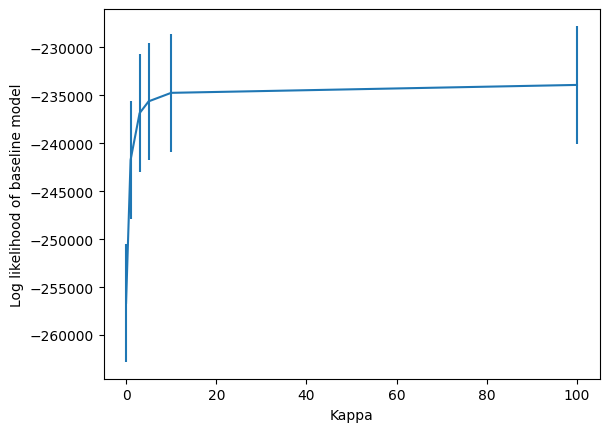

In [58]:
plt.errorbar([0, 1, 3, 5, 10, 100], np.mean(np.array(pd.DataFrame(all_baseline_lls)), axis=0), yerr=np.std(np.array(pd.DataFrame(all_baseline_lls)), axis=0))
# plt.errorbar([0, 1, 3, 5, 10, 100], np.std(np.array(pd.DataFrame(all_baseline_lls)), axis=0))
plt.ylabel('Log likelihood of baseline model')
# plt.scatter([0, 1, 3, 5, 10, 100], np.mean(np.array(pd.DataFrame(all_lls)), axis=0))
plt.xlabel('Kappa')
# plt.ylabel('Log likelihood of fit model')

(-7760.0, -7740.0)

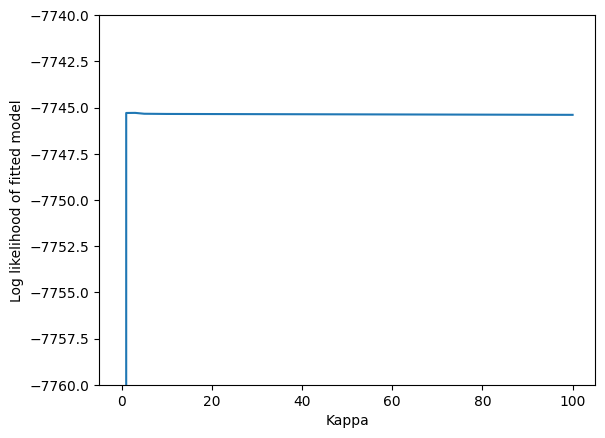

In [65]:
# plt.errorbar([0, 1, 3, 5, 10, 100], np.mean(np.array(pd.DataFrame(all_lls)), axis=0), yerr=np.std(np.array(pd.DataFrame(all_lls)), axis=0))
plt.plot([0, 1, 3, 5, 10, 100], np.mean(np.array(pd.DataFrame(all_lls)), axis=0))
# plt.errorbar([0, 1, 3, 5, 10, 100], np.std(np.array(pd.DataFrame(all_baseline_lls)), axis=0))
plt.ylabel('Log likelihood of fitted model')
# plt.scatter([0, 1, 3, 5, 10, 100], np.mean(np.array(pd.DataFrame(all_lls)), axis=0))
plt.xlabel('Kappa')
plt.ylim(-7760, -7740)
# plt.ylabel('Log likelihood of fit model')